# Modeli strojnog učenja


[*Jupyter*](https://jupyter.org/) bilježnica Davora Penzara u sklopu diplomskog rada ($ 2020 $. godine na [*Matematičkom odsjeku*](https://www.math.pmf.unizg.hr/) [*Prirodoslovno-matematičkog fakulteta*](https://www.pmf.unizg.hr/) [*Sveučilišta u Zagrebu*](http://www.unizg.hr/)).

U ovoj su bilježnici predstavljeni modeli strojnog učenja kao programska rješenja opisana u diplosmkom radu.


## Sadržaj <a class="anchor" id="table-of-contents"></a>


1.  [Priprema okruženja](#environment-preparation)
2.  [Linearna regresija](#linear-regression)
    1.  [Polinom stupnja $ 4 $](#lr-polynomial-4)
    2.  [Polinom stupnja $ 5 $](#lr-polynomial-5)
    3.  [Zaključak](#lr-conclusion)
3.  [Neuronska mreža](#neural-network)
    1.  [Zaključak](#nn-conclusion)
4.  [Konvolucijska neuronska mreža](#convolutional-neural-network)
    1.  [Zaključak](#cnn-conclusion)
5.  [Minimizacija $ \lambda_{1} $ za fiksni opseg trokuta](#fixed-circumference-lambda-minimisation)
    1.  [Manipulacija trokutima](#min-triangles-manipulation)
    2.  [Učitavanje modela](#min-models-loading)
    3.  [Minimizacija funkcijom [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)](#min-minimisation-using-scipy-optimize-minimize)
    4.  [Zaključak](#min-conclusion)
6.  [Zaključak](#conclusion)
7.  [Bibliografija](#bibliography)


## Priprema okruženja <a class="anchor" id="environment-preparation"></a>


Učitavanje potrebnih paketa&hellip;


In [0]:
# Import IPython.
from IPython import *
from IPython.display import *


In [0]:
# Import standard library.
import copy
import enum
import functools
import gc
import math
import numbers
import six
import sys
import time


In [0]:
# Import SciPy packages.
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sym
import scipy as sp
import scipy.optimize as spopt
from mpl_toolkits.mplot3d import Axes3D


(izbriši `#` s početka sljedeće linije za učitavanje [*TensorFlow*](https://www.tensorflow.org/) verzije 2.x)


In [0]:
#%tensorflow_version 2.x


In [4]:
# Import TensorFlow.
import tensorflow as tf


In [0]:
# Import SciKit Learn.
import sklearn as sk
import sklearn.linear_model as lm


In [6]:
# Import Keras.
import keras as k
import keras.activations as ka
import keras.backend as K
import keras.callbacks as kc
import keras.layers as kl
import keras.losses as ke
import keras.models as km
import keras.optimizers as ko


Using TensorFlow backend.


In [0]:
# Import Joblib.
import joblib as jl


Za spajanje na [*Google Drive*](https://drive.google.com/) učitaj i sljedeće pakete (ako se [*Jupyter*](https://jupyter.org/) bilježnica izvršava lokalno, sljedeća čelija nije potrebna, ali se sadržaj kasnijih čelija mora mijenjati).


In [0]:
# Import Google Colab.
import google
import google.colab as colab


Namještavanje okruženja&hellip;


In [0]:
%matplotlib inline


In [0]:
#sym.init_printing()


In [0]:
plt.style.use('default')


Spajanje na [*Google Drive*](https://drive.google.com/)&hellip;


In [11]:
colab.drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Navigiranje u direktorij na [*Google Drive*u](https://drive.google.com/)&hellip;


In [12]:
%cd '/content/drive/My Drive/destination_folder'


/content/drive/My Drive/destination_folder


(izbriši `#` s početka sljedeće linije za kloniranje [*GitHub*](https://github.com/) repozitorija s potrebnim materijalima)


In [0]:
#!git clone https://github.com/DavorPenzar/diplomski.git


Navigiranje u direktorij kloniranog [*GitHub*](https://github.com/) repozitorija&hellip;


In [13]:
%cd diplomski


/content/drive/My Drive/destination_folder/diplomski


Dohvaćanje najnovije verzije [*GitHub*](https://github.com/) repozitorija&hellip;


In [0]:
!git fetch


In [15]:
!git pull origin


Already up to date.


Navigiranje u poddirektorij s k&ocirc;dovima&hellip;


In [16]:
%cd code


/content/drive/My Drive/destination_folder/diplomski/code


**Uspoređivanje inačica paketa s inačicama paketa na kojima su se modeli razvijali i testirali&hellip;**


Inačice paketa pri razvoju modela&hellip;


In [17]:
!cat models/environment_info.txt


Python version:
	3.6.9 (default, Nov  7 2019, 10:44:02)
	[GCC 8.3.0]
SciPy version: 1.4.1
NumPy version: 1.17.5
Pandas version: 0.25.3
Matplotlib version: 3.1.2
TensorFlow version: 1.15.0
Keras version: 2.2.5
Scikit-learn version: 0.22.1
Joblib version: 0.14.1


Inačice korištenih paketa&hellip;


In [18]:
print(
    "Python version:\n\t{v:s}".format(
        v = sys.version.strip().replace("\n", "\n\t")
    )
)
print("SciPy version: {v:s}".format(v = sp.__version__))
print("NumPy version: {v:s}".format(v = np.__version__))
print("Pandas version: {v:s}".format(v = pd.__version__))
print("Matplotlib version: {v:s}".format(v = mpl.__version__))
print("TensorFlow version: {v:s}".format(v = tf.__version__))
print("Keras version: {v:s}".format(v = k.__version__))
print("Scikit-learn version: {v:s}".format(v = sk.__version__))
print("Joblib version: {v:s}".format(v = jl.__version__))


Python version:
	3.6.9 (default, Nov  7 2019, 10:44:02) 
	[GCC 8.3.0]
SciPy version: 1.4.1
NumPy version: 1.17.5
Pandas version: 0.25.3
Matplotlib version: 3.1.2
TensorFlow version: 1.15.0
Keras version: 2.2.5
Scikit-learn version: 0.22.1
Joblib version: 0.14.1


Učitavanje vlastitih [*Python*](https://www.python.org/) skripti&hellip;


In [0]:
from usefulness import *
from MST_CNN import *


Definiranje dodatnih klasa i funkcija za olakšani kasniji rad&hellip;


Definiranje enumeracijske klase za označavanje podskupova podataka (koordinate točaka, numeričke značajke i ciljna varijabla) i funkcije za učitavanje podataka&hellip;


In [0]:
class DataSubSet (enum.IntEnum):
    """
    Enumeration notation of dataset subsets.

    Elementary subsets and its notation values are:
        coordinates     =  1    = 0b00001
        characteristics =  2    = 0b00010
        descritpions    =  4    = 0b00100
        singular_values =  8    = 0b01000
        eigenvalues     = 16    = 0b10000

    Combined subsets can be denoted using elementary subset notation and the
    binary or operator, such as
        >>> DataSubSet.descriptions | DataSubSet.singular_values | DataSubSet.eigenvalues
        28
    or by using the exact value (28 in the case above).  Splitting a combined
    subset on elementary subsets can be done using the binary and operator, such
    as
        >>> bool(28 & DataSubSet.singular_values)
        True
        >>> bool(28 & DataSubSet.coordinates)
        False

    Caution: the "descriptions" dataset is actually the sorted descriptions
    dataset.

    """

    # Define the elementary subsets' notations.
    coordinates     = 0b00001
    characteristics = 0b00010
    descriptions    = 0b00100
    singular_values = 0b01000
    eigenvalues     = 0b10000

    # Define the order of the subsets' notations.
    __order__ = (
        'coordinates characteristics descriptions singular_values eigenvalues'
    )


In [0]:
def load_df (
    superset,
    which,
    subset = (DataSubSet.coordinates | DataSubSet.eigenvalues)
):
    """
    Load a dataset as a Pandas dataframe.

    Parameters
    ==========
    superset : {'numerical', 'imagination'}
        Dataset collection from which to load the dataset.

    which : {'train', 'validation', 'test'}
        Which dataset to load.

    subset : int in range [1, 31], optional
        Enumeration notation of the subset to load (see the documentation for
        `DataSubSet`) (default is 17, i. e. coordinates and eigenvalues).

    Returns
    =======
    DataFrame
        Dataframe of the desired dataset.

    """

    # Initialise the list of dataframes to an empty list.
    dfs = list()

    # Add the desired dataframes to the list `dfs`.
    if (subset & DataSubSet.coordinates):
        dfs.append(
            read_tsv(
                "data/{sup:s}/{at:s}/coordinates.tsv".format(
                    sup = superset,
                    at = which
                ),
                names = ['x_0', 'y_0', 'x_1', 'y_1', 'x_2', 'y_2']
            )
        )
    if (subset & DataSubSet.characteristics):
        dfs.append(
            read_tsv(
                "data/{sup:s}/{at:s}/characteristics.tsv".format(
                    sup = superset,
                    at = which
                ),
                names = ['x_char', 'y_char']
            )
        )
    if (subset & DataSubSet.descriptions):
        dfs.append(
            read_tsv(
                "data/{sup:s}/{at:s}/sorted_descriptions.tsv".format(
                    sup = superset,
                    at = which
                ),
                names = ['a', 'c', 'b', 'alpha', 'gamma', 'beta']
            )
        )
    if (subset & DataSubSet.singular_values):
        dfs.append(
            read_tsv(
                "data/{sup:s}/{at:s}/singular_values.tsv".format(
                    sup = superset,
                    at = which
                ),
                names = [
                    'sv_edge_0',
                    'sv_edge_1',
                    'sv_edge_2',
                    'sv_angle_0',
                    'sv_angle_1',
                    'sv_angle_2'
                ]
            )
        )
    if (subset & DataSubSet.eigenvalues):
        dfs.append(
            read_tsv(
                "data/{sup:s}/{at:s}/eigenvalues.tsv".format(
                    sup = superset,
                    at = which
                ),
                names = ['l_0']
            )
        )

    # Concatenate the dataframes in the list `dfs` and return them.
    return (
        pd.concat(dfs, axis = 1) if dfs
            else pd.DataFrame(np.zeros((0, 0), dtype = float, order = 'C'))
    )


Definiranje pomoćne klase za učitavanje i spremanje skupova podataka&hellip;

S klasom `DataSet` moguće je učitati sve podatke (za trening, validaciju i testiranje) odjednom i olakšana je manipulacija podatcima. Na primjer, moguće je sljedeće:

```Python
num = DataSet('numerical')  # Učitaj sve podatke iz 'data/numerical'.
num.train.describe()        # Dohvati deskriptivu učitanih podataka za treniranje.
```


In [0]:
class DataSet (object):
    """
    Class for representing dataset collections.

    Parameters
    ==========
    name : {'numerical', 'imagination'}
        Dataset collection (see documentation for parameter `superset` at
        `load_df`).

    subset : int in range [1, 31], optional
        Enumeration notation of the subsets to load (see the documentation for
        parameter `subset` at `load_df`) (default is 31, i. e. all subsets).

    """

    def __new__ (cls, name = str(), subset = 0):
        # Create a new instance.
        ds = super(DataSet, cls).__new__(cls)

        # Initialise all attributes as `None`.
        ds._name = None
        ds._train = None
        ds._validation = None
        ds._test = None

        # Return the created instance.
        return ds

    def __init__ (self, name, subset = 31):
        # Initialise the instance of the super class.
        super(DataSet, self).__init__()

        # Set the instance's attributes.
        self._name = copy.deepcopy(str(name))
        self._train = load_df(self._name, 'train', subset)
        self._validation = load_df(self._name, 'validation', subset)
        self._test = load_df(self._name, 'test', subset)

    def __copy__ (self):
        """
        Return `copy.copy(self)`.

        """

        # Create a new instance.
        ds = DataSet.__new__(DataSet)

        # Copy the attributes from `self`.
        ds._name = self._name
        ds._train = self._train
        ds._validation = self._validation
        ds._test = self._test

        # Return the created copy.
        return ds

    def __deepcopy__ (self, memo = dict(), _nil = list()):
        """
        Return `copy.deepcopy(self, memo, _nil)`.

        """

        # Create a new instance.
        ds = DataSet.__new__(DataSet)

        # Copy the attributes from `self`.
        ds._name = copy.deepcopy(self._name, memo, _nil)
        ds._train = self._train.copy(deep = True)
        ds._validation = self._validation.copy(deep = True)
        ds._test = self._test.copy(deep = True)

        # Return the created copy.
        return ds

    def join_validation_test (self):
        """
        Move the validation set to the testing set joining the two with ignoring the indices.

        Caution: the validation data will be cleared.

        """

        # Join the validation and the testing data into the testing data.
        self._test = pd.concat(
            (self._validation, self._test),
            axis = 0,
            ignore_index = True
        )

        # Clear the validation data.
        if self._validation.shape[0]:
            self._validation = self._validation.iloc[0:0].copy(deep = True)
        else:
            self._validation = self._validation.copy(deep = True)

    def __repr__ (self):
        """
        Return `repr(self)`.

        """

        return "<DataSet of {name:s}>".format(name = self._name)

    def __iter__ (self):
        """
        Iterate over the training, validation and testing sets (in that order).

        """

        yield self._train
        yield self._validation
        yield self._test

    @property
    def name (self):
        """
        Name of the dataset collection (`str`).

        """

        return copy.deepcopy(self._name)

    @property
    def train (self):
        """
        Trainig set (`pandas.DataFrame`).

        """

        return self._train

    @property
    def validation (self):
        """
        Validation set (`pandas.DataFrame`).

        """

        return self._validation

    @property
    def test (self):
        """
        Testing set (`pandas.DataFrame`).

        """

        return self._test


Definiranje vlastite aktivacijske funkcije `ReLU`$ {} \circ x \mapsto x^{{- 1}} $&hellip;


In [0]:
def relu_mult_inv (x):
    """
    Return `relu(x ** -1)`.

    """

    return K.relu(K.pow(x, -1))


Definiranje pomoćne funkcije za konstruiranje članova polinoma&hellip;


In [0]:
def polynomial_terms_creator (n):
    """
    Construct a function for generating variables of a polynomial of degree n in two variables.

    """

    # Construct the function.
    def polynomial_terms (x, y):
        # Initialise the list of terms to `None`s.
        terms = list(None for i in six.moves.range((n + 2) * (n + 1) // 2 - 1))
        try:
            del i
        except (NameError, UnboundLocalError):
            pass

        # Initialise the index to 0.
        i = 0

        # Construct the terms.
        for k in six.moves.range(1, n + 1):
            # Construct the term `x ** k` and increment the index `i`.
            terms[i] = (x ** k if k > 1 else x)
            i += 1

            # Construct all terms `x ** (k - r) * y ** r` for `r` in
            # [2 .. k - 1] and increment the index `i` after creating each term.
            for r in six.moves.range(1, k):
                terms[i] = (
                    (x ** (k - r) if k - r > 1 else x) *
                    (y ** r if r > 1 else y)
                )
                i += 1

            # Construct the term `y ** k`.
            terms[i] = (y ** k if k > 1 else y)
            i += 1
        try:
            del k
        except (NameError, UnboundLocalError):
            pass

        # Free the memory.
        del i

        # Return the constructed list of terms.
        return terms

    # Return the constructed function.
    return polynomial_terms


Definiranje pomoćne funkcije za računanje greške na [*NumPy*](https://numpy.org/) poljima&hellip;


In [0]:
def errors (y_true, y_predicted):
    """
    Get the MSE, MAE and MAPE of NumPy arrays.

    """

    return {
        'MSE' : np.mean(np.square(np.subtract(y_true, y_predicted))),
        'MAE' : np.mean(np.absolute(np.subtract(y_true, y_predicted))),
        'MAPE' :
            (
                100.0 *
                np.mean(
                    np.absolute(
                        np.divide(np.subtract(y_true, y_predicted), y_true)
                    )
                )
            )
    }


Učitavanje postavki grafova (granice prikaza, oznake vrijednosti&hellip;)&hellip;


In [0]:
from limits_ticks import *


Učitavanje $ 5 \, \% $-thih kvantila ciljne varijable&hellip;


In [0]:
l_0_quant = np.load('data/arrays/l_quantiles.npy')


## Linearna regresija <a class="anchor" id="linear-regression"></a>


Konstruiranje pomoćnih varijabli za konstrukciju notacije članova polinoma.


In [0]:
x = sym.Symbol('x', real = True)
y = sym.Symbol('y', real = True)


Učitavanje skupa podataka&hellip;


In [0]:
num = DataSet('numerical', DataSubSet.coordinates | DataSubSet.eigenvalues)
num.join_validation_test()


### Polinom stupnja $ 4 $ <a class="anchor" id="lr-polynomial-4"></a>


Definiranje stupnja polinoma kao varijable `n`&hellip;


In [0]:
n = 4


Konstruiranje funkcije za generiranje članova polinoma&hellip;


In [0]:
polynomial_terms = polynomial_terms_creator(n)


Konstruiranje indeksa stupaca s članovima polinoma&hellip;


In [0]:
polynomial_index = pd.Index(
    list(str(term) for term in polynomial_terms(x, y)),
    dtype = str,
    copy = True
)
try:
    del term
except (NameError, UnboundLocalError):
    pass


Računanje članova polinoma&hellip;


In [0]:
for df in iter(num):
    for term_ind, term in zip(
        polynomial_index,
        polynomial_terms(df.x_1, df.y_1)
    ):
        df[term_ind] = term
    try:
        del term_ind
    except (NameError, UnboundLocalError):
        pass
    try:
        del term
    except (NameError, UnboundLocalError):
        pass
try:
    del df
except (NameError, UnboundLocalError):
    pass


**Konstruiranje modela linearne regresije kao instance klase `scikit.linear_model.LinearRegression` za računanje koeficijenata polinoma&hellip;**


In [0]:
model = lm.LinearRegression()


**Treniranje modela&hellip;**


(izbriši `#` ispred linija

```Python
model.fit(num.train[polynomial_index], num.train.l_0 ** -1)
jl.dump(model, 'models/polynomial_4.gz', compress = 3)
```

za stvarno treniranje i spremanje modela respektivno)


In [0]:
# Train the model.
#model.fit(num.train[polynomial_index], num.train.l_0 ** -1)

# Save the model.
#jl.dump(model, 'models/polynomial_4.gz', compress = 3)

# Delete the model.
del model

# Load the model.
model = jl.load('models/polynomial_4.gz')


**Dohvaćanje koeficijenata polinoma&hellip;**


Slobodni član


In [36]:
model.intercept_


-2.010154572221201e-05

Vezani koeficijenti


In [37]:
model.coef_


array([ 1.86432232e-05,  1.05705665e-03, -1.39305244e-03,  2.52679066e-03,
        7.17536930e-02,  3.16331976e-03,  1.15877955e-03, -1.00715309e-02,
       -8.35010891e-02, -6.66294235e-04, -1.07584242e-02, -1.04812081e-02,
        9.23778068e-03,  3.28964982e-02])

**Predviđanje na testnom skupu podataka&hellip;**


In [0]:
l_0_inv_predicted = model.predict(num.test[polynomial_index])


**Računanje greške na testnom skupu podataka&hellip;**


Na cijelom skupu&hellip;


In [39]:
errors(num.test.l_0, l_0_inv_predicted ** -1)


{'MAE': 7.270954420736801,
 'MAPE': 0.4967814283016116,
 'MSE': 1333.7506801430147}

Po $ 5 \, \% $-tnim kvantilima&hellip;


In [40]:
# Display errors on 5 % quantiles.
for i in six.moves.range(int(l_0_quant.size) - 1):
    # Extract the indices of the `i`-th quantile.
    I = (num.test.l_0 >= l_0_quant[i]) & (num.test.l_0 < l_0_quant[i + 1])

    # Display the error on the `i`-th quantile.
    print(
        "{ind:2d}: {low:7.2f} -- {high:7.2f}".format(
            ind = i + 1,
            low = l_0_quant[i],
            high = l_0_quant[i + 1]
        )
    )
    display(errors(num.test.loc[I, 'l_0'], l_0_inv_predicted[I] ** -1))
    print(str())

    # Free the memory.
    del I
try:
    del i
except (NameError, UnboundLocalError):
    pass


 1:   52.72 --   55.41


{'MAE': 0.026451793542631098,
 'MAPE': 0.048674496753512674,
 'MSE': 0.001082211218709001}


 2:   55.41 --   58.46


{'MAE': 0.02594822696330964,
 'MAPE': 0.045399150115432614,
 'MSE': 0.0010020938147126336}


 3:   58.46 --   62.06


{'MAE': 0.034680830910445756,
 'MAPE': 0.05752216145724119,
 'MSE': 0.0016432601718666658}


 4:   62.06 --   66.20


{'MAE': 0.027204282930385116,
 'MAPE': 0.04252787218986493,
 'MSE': 0.0011595786837492548}


 5:   66.20 --   71.01


{'MAE': 0.03496360693380909,
 'MAPE': 0.050784147496291836,
 'MSE': 0.0021032597277842006}


 6:   71.01 --   76.74


{'MAE': 0.04978760779069682,
 'MAPE': 0.0672943227072742,
 'MSE': 0.003879178337738166}


 7:   76.74 --   83.51


{'MAE': 0.050007414310019614,
 'MAPE': 0.06238410177025553,
 'MSE': 0.004508557457363612}


 8:   83.51 --   91.80


{'MAE': 0.059100053655418,
 'MAPE': 0.06735962960167502,
 'MSE': 0.005504347403186908}


 9:   91.80 --  102.00


{'MAE': 0.07795781777670598,
 'MAPE': 0.0800774844067911,
 'MSE': 0.010866834206272196}


10:  102.00 --  114.76


{'MAE': 0.1448986794509584,
 'MAPE': 0.1338118159545535,
 'MSE': 0.0358707113892907}


11:  114.76 --  130.69


{'MAE': 0.19669878116760683,
 'MAPE': 0.15888534105741317,
 'MSE': 0.06507965864485542}


12:  130.69 --  152.54


{'MAE': 0.5379140069290752,
 'MAPE': 0.37935527929891655,
 'MSE': 0.3959144618985805}


13:  152.54 --  181.99


{'MAE': 0.8495229847098685,
 'MAPE': 0.5089853973265923,
 'MSE': 1.0203010639936956}


14:  181.99 --  221.86


{'MAE': 1.0074068460345138,
 'MAPE': 0.5008007363918374,
 'MSE': 2.17384146245197}


15:  221.86 --  282.86


{'MAE': 1.256572361132455,
 'MAPE': 0.4969241782998765,
 'MSE': 2.4017101932351514}


16:  282.86 --  381.22


{'MAE': 3.4302899659188695,
 'MAPE': 1.0266879051241324,
 'MSE': 17.2053171140653}


17:  381.22 --  541.76


{'MAE': 4.451004283214466, 'MAPE': 0.9958515139898051, 'MSE': 30.2575747334796}


18:  541.76 --  861.51


{'MAE': 4.82555770459644, 'MAPE': 0.7094174726155087, 'MSE': 36.38835341426432}


19:  861.51 -- 1714.84


{'MAE': 13.19074618010058,
 'MAPE': 1.0326358178174904,
 'MSE': 432.91042069614934}


20: 1714.84 -- 5942.29


{'MAE': 115.14237498666658,
 'MAPE': 3.470249741657815,
 'MSE': 26152.127470029758}

**Grafički prikaz točnosti predviđanja&hellip;**


Na cijelom skupu&hellip;


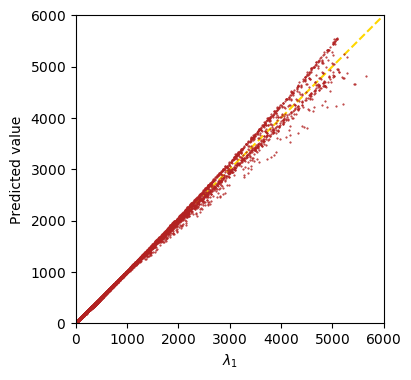

In [41]:
# Create a figure.
fig = plt.figure(num = 'Prediction error', figsize = (4.0, 4.0))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the subplot to equal.
ax.set_aspect('equal')

# Plot the identity line.
ax.plot(
    [l_0_quant[0], l_0_quant[-1]],
    [l_0_quant[0], l_0_quant[-1]],
    color = 'gold',
    linestyle = '--',
    marker = 'None'
)

# Plot lambda_0 prediction over true lambda_0.
ax.plot(
    num.test.l_0,
    l_0_inv_predicted ** -1,
    color = 'firebrick',
    linestyle = 'None',
    marker = '.',
    ms = 1
)

# Set axis labels.
ax.set_xlabel("$ \\lambda_{1} $")
ax.set_ylabel('Predicted value')

# Set ticks.
ax.set_xticks(ticks['l_0'])
ax.set_yticks(ticks['l_0'])

# Set tick labels.
ax.set_xticklabels(ticklabels['l_0'])
ax.set_yticklabels(ticklabels['l_0'])

# Set axis limits.
ax.set_xlim(lim['l_0'])
ax.set_ylim(lim['l_0'])

# Save the figure.
fig.savefig('polynomial_4_prediction.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


Na donjih $ 90 \, \% $&hellip;


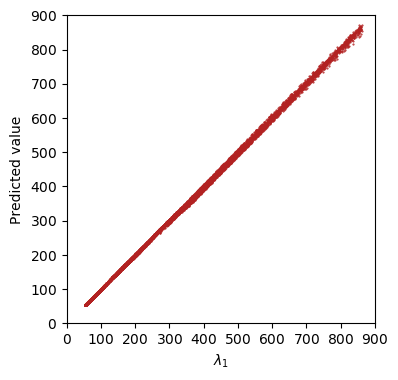

In [43]:
# Create a figure.
fig = plt.figure(num = 'Prediction error', figsize = (4.0, 4.0))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the subplot to equal.
ax.set_aspect('equal')

# Plot the identity line.
ax.plot(
    [l_0_quant[0], l_0_quant[-3] + 1.0e-8],
    [l_0_quant[0], l_0_quant[-3] + 1.0e-8],
    color = 'gold',
    linestyle = '--',
    marker = 'None'
)

# Plot lambda_0 prediction over true lambda_0.
ax.plot(
    num.test.loc[num.test.l_0 < l_0_quant[-3] + 1.0e-8, 'l_0'],
    l_0_inv_predicted[num.test.l_0 < l_0_quant[-3] + 1.0e-8] ** -1,
    color = 'firebrick',
    linestyle = 'None',
    marker = '.',
    ms = 1
)

# Set axis labels.
ax.set_xlabel("$ \\lambda_{1} $")
ax.set_ylabel('Predicted value')

# Set ticks.
ax.set_xticks(ticks['l_0_90_pc'])
ax.set_yticks(ticks['l_0_90_pc'])

# Set tick labels.
ax.set_xticklabels(ticklabels['l_0_90_pc'])
ax.set_yticklabels(ticklabels['l_0_90_pc'])

# Set axis limits.
ax.set_xlim(lim['l_0_90_pc'])
ax.set_ylim(lim['l_0_90_pc'])

# Save the figure.
fig.savefig('polynomial_4_prediction_90_percent.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


In [0]:
# Free the memory.
num.train.drop(polynomial_index, axis = 1, inplace = True)
del n
del polynomial_terms
del polynomial_index
del model
del l_0_inv_predicted


### Polinom stupnja $ 5 $ <a class="anchor" id="lr-polynomial-5"></a>


Definiranje stupnja polinoma kao varijable `n`&hellip;


In [0]:
n = 5


Konstruiranje funkcije za generiranje članova polinoma&hellip;


In [0]:
polynomial_terms = polynomial_terms_creator(n)


Konstruiranje indeksa stupaca s članovima polinoma&hellip;


In [0]:
polynomial_index = pd.Index(
    list(str(term) for term in polynomial_terms(x, y)),
    dtype = str,
    copy = True
)
try:
    del term
except (NameError, UnboundLocalError):
    pass


Računanje članova polinoma&hellip;


In [0]:
for df in iter(num):
    for term_ind, term in zip(
        polynomial_index,
        polynomial_terms(df.x_1, df.y_1)
    ):
        df[term_ind] = term
    try:
        del term_ind
    except (NameError, UnboundLocalError):
        pass
    try:
        del term
    except (NameError, UnboundLocalError):
        pass
try:
    del df
except (NameError, UnboundLocalError):
    pass


**Konstruiranje modela linearne regresije kao instance klase `scikit.linear_model.LinearRegression` za računanje koeficijenata polinoma&hellip;**


In [0]:
model = lm.LinearRegression()


**Treniranje modela&hellip;**


(izbriši `#` ispred linija

```Python
model.fit(num.train[polynomial_index], num.train.l_0 ** -1)
jl.dump(model, 'models/polynomial_5.gz', compress = 3)
```

za stvarno treniranje i spremanje modela respektivno)


In [0]:
# Train the model.
#model.fit(num.train[polynomial_index], num.train.l_0 ** -1)

# Save the model.
#jl.dump(model, 'models/polynomial_5.gz', compress = 3)

# Delete the model.
del model

# Load the model.
model = jl.load('models/polynomial_5.gz')


**Dohvaćanje koeficijenata polinoma&hellip;**


Slobodni član


In [52]:
model.intercept_


-1.5863418179834152e-05

Vezani koeficijenti


In [53]:
model.coef_


array([-1.00479834e-03,  1.27109239e-03,  1.51762635e-02,  3.27179136e-05,
        7.10673999e-02, -6.79083968e-02, -5.06740147e-02,  2.72541611e-02,
       -8.50918423e-02,  1.25538959e-01,  1.67171185e-01, -2.93886758e-03,
       -6.26566121e-02,  3.87161319e-02, -8.41070953e-02, -1.45508207e-01,
       -9.54913415e-02,  4.34678097e-02,  3.77676598e-02, -3.94042121e-03])

**Predviđanje na testnom skupu podataka&hellip;**


In [0]:
l_0_inv_predicted = model.predict(num.test[polynomial_index])


**Računanje greške na testnom skupu podataka&hellip;**


Na cijelom skupu&hellip;


In [55]:
errors(num.test.l_0, l_0_inv_predicted ** -1)


{'MAE': 5.982228812599361,
 'MAPE': 0.45509733922891976,
 'MSE': 875.4654835573298}

Po $ 5 \, \% $-tnim kvantilima&hellip;


In [56]:
# Display errors on 5 % quantiles.
for i in six.moves.range(int(l_0_quant.size) - 1):
    # Extract the indices of the `i`-th quantile.
    I = (num.test.l_0 >= l_0_quant[i]) & (num.test.l_0 < l_0_quant[i + 1])

    # Display the error on the `i`-th quantile.
    print(
        "{ind:2d}: {low:7.2f} -- {high:7.2f}".format(
            ind = i + 1,
            low = l_0_quant[i],
            high = l_0_quant[i + 1]
        )
    )
    display(errors(num.test.loc[I, 'l_0'], l_0_inv_predicted[I] ** -1))
    print(str())

    # Free the memory.
    del I
try:
    del i
except (NameError, UnboundLocalError):
    pass


 1:   52.72 --   55.41


{'MAE': 0.017093920805952685,
 'MAPE': 0.03144552828605811,
 'MSE': 0.0005232116667473563}


 2:   55.41 --   58.46


{'MAE': 0.021345775200398674,
 'MAPE': 0.03733124530934451,
 'MSE': 0.0006269011117754319}


 3:   58.46 --   62.06


{'MAE': 0.026851096740880764,
 'MAPE': 0.044548391206963675,
 'MSE': 0.0010533375695055743}


 4:   62.06 --   66.20


{'MAE': 0.024372831422800913,
 'MAPE': 0.03800596071078503,
 'MSE': 0.00103707789616265}


 5:   66.20 --   71.01


{'MAE': 0.034371636609864885,
 'MAPE': 0.04998855048439437,
 'MSE': 0.0018235853445664832}


 6:   71.01 --   76.74


{'MAE': 0.04335032372816614,
 'MAPE': 0.05861419864718081,
 'MSE': 0.0028756192326833616}


 7:   76.74 --   83.51


{'MAE': 0.04112676631900292,
 'MAPE': 0.051192948737865396,
 'MSE': 0.00324117913999059}


 8:   83.51 --   91.80


{'MAE': 0.06544042672451159,
 'MAPE': 0.07446155254462379,
 'MSE': 0.006415748046420115}


 9:   91.80 --  102.00


{'MAE': 0.0851898084667885,
 'MAPE': 0.08750803975360898,
 'MSE': 0.01252823336653639}


10:  102.00 --  114.76


{'MAE': 0.14594177198425207,
 'MAPE': 0.1348578502447904,
 'MSE': 0.03218986709312481}


11:  114.76 --  130.69


{'MAE': 0.18110807240396326,
 'MAPE': 0.14654393609152166,
 'MSE': 0.052704837788501054}


12:  130.69 --  152.54


{'MAE': 0.5195351589407577,
 'MAPE': 0.3659032179015256,
 'MSE': 0.38844518051725535}


13:  152.54 --  181.99


{'MAE': 0.8403736007450959,
 'MAPE': 0.5030661673284142,
 'MSE': 1.0011222827790565}


14:  181.99 --  221.86


{'MAE': 1.0126579720375388,
 'MAPE': 0.5047629054693493,
 'MSE': 2.2035293038271324}


15:  221.86 --  282.86


{'MAE': 1.1912451356666776,
 'MAPE': 0.4711774263558438,
 'MSE': 2.2485283507589298}


16:  282.86 --  381.22


{'MAE': 3.253216028163914,
 'MAPE': 0.9751677529259981,
 'MSE': 15.348548938995132}


17:  381.22 --  541.76


{'MAE': 3.6617630860598886,
 'MAPE': 0.8210839886640872,
 'MSE': 21.392404241579793}


18:  541.76 --  861.51


{'MAE': 5.657629392470387, 'MAPE': 0.814663667975491, 'MSE': 47.86257895826846}


19:  861.51 -- 1714.84


{'MAE': 16.208380971577412,
 'MAPE': 1.3081310410803444,
 'MSE': 428.9157402011634}


20: 1714.84 -- 5942.29


{'MAE': 86.61358247591883, 'MAPE': 2.583492414860269, 'MSE': 16989.83375409039}

**Grafički prikaz točnosti predviđanja&hellip;**


Na cijelom skupu&hellip;

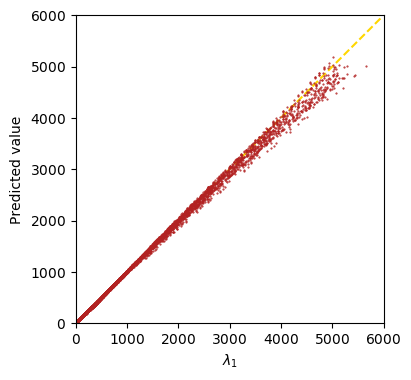

In [57]:
# Create a figure.
fig = plt.figure(num = 'Prediction error', figsize = (4.0, 4.0))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the subplot to equal.
ax.set_aspect('equal')

# Plot the identity line.
ax.plot(
    [l_0_quant[0], l_0_quant[-1]],
    [l_0_quant[0], l_0_quant[-1]],
    color = 'gold',
    linestyle = '--',
    marker = 'None'
)

# Plot lambda_0 prediction over true lambda_0.
ax.plot(
    num.test.l_0,
    l_0_inv_predicted ** -1,
    color = 'firebrick',
    linestyle = 'None',
    marker = '.',
    ms = 1
)

# Set axis labels.
ax.set_xlabel("$ \\lambda_{1} $")
ax.set_ylabel('Predicted value')

# Set ticks.
ax.set_xticks(ticks['l_0'])
ax.set_yticks(ticks['l_0'])

# Set tick labels.
ax.set_xticklabels(ticklabels['l_0'])
ax.set_yticklabels(ticklabels['l_0'])

# Set axis limits.
ax.set_xlim(lim['l_0'])
ax.set_ylim(lim['l_0'])

# Save the figure.
fig.savefig('polynomial_5_prediction.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


Na donjih $ 90 \, \% $&hellip;


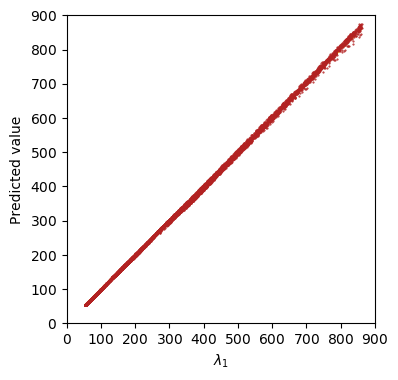

In [59]:
# Create a figure.
fig = plt.figure(num = 'Prediction error', figsize = (4.0, 4.0))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the subplot to equal.
ax.set_aspect('equal')

# Plot the identity line.
ax.plot(
    [l_0_quant[0], l_0_quant[-3] + 1.0e-8],
    [l_0_quant[0], l_0_quant[-3] + 1.0e-8],
    color = 'gold',
    linestyle = '--',
    marker = 'None'
)

# Plot lambda_0 prediction over true lambda_0.
ax.plot(
    num.test.loc[num.test.l_0 < l_0_quant[-3] + 1.0e-8, 'l_0'],
    l_0_inv_predicted[num.test.l_0 < l_0_quant[-3] + 1.0e-8] ** -1,
    color = 'firebrick',
    linestyle = 'None',
    marker = '.',
    ms = 1
)

# Set axis labels.
ax.set_xlabel("$ \\lambda_{1} $")
ax.set_ylabel('Predicted value')

# Set ticks.
ax.set_xticks(ticks['l_0_90_pc'])
ax.set_yticks(ticks['l_0_90_pc'])

# Set tick labels.
ax.set_xticklabels(ticklabels['l_0_90_pc'])
ax.set_yticklabels(ticklabels['l_0_90_pc'])

# Set axis limits.
ax.set_xlim(lim['l_0_90_pc'])
ax.set_ylim(lim['l_0_90_pc'])

# Save the figure.
fig.savefig('polynomial_5_prediction_90_percent.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


In [0]:
# Free the memory.
num.train.drop(polynomial_index, axis = 1, inplace = True)
del n
del polynomial_terms
del polynomial_index
del model
del l_0_inv_predicted


### Zaključak <a class="anchor" id="lr-conclusion"></a>


Razvijeni modeli polinoma luče solidne rezultate iako se korijen srednje kvadratne greške od $ 36.5206 $ odnosno $ 29.5883 $ čini visokim. No, kako vrijednost koju modeli predviđaju ima veliki raspon, apsolutno velike greške na *visokim* vrijednostima mogu biti relativno male, ali pritom jako utječu na srednju kvadratnu grešku cijelog modela. Stoga srednja apsolutna postotna greška od $ 0.4968 \, \% $ odnosno $ 0.45510 \, \% $ daje bolji uvid u točnost ovih modela. Osim toga, relativne greške po kvantilima ciljne varijable također ukazuju na solidnu točnost ovih modela; doduše, točnost modela (i apsolutna i relativna) opada s porastom ciljne varijable.


In [0]:
# Free the memory.
del num
del x
del y


## Neuronska mreža <a class="anchor" id="neural-network"></a>


Učitavanje podataka&hellip;


In [0]:
num = DataSet(
    'numerical',
    DataSubSet.descriptions |
        DataSubSet.singular_values |
        DataSubSet.eigenvalues
)


Stupac *a* je konstantan (najdulja stranica svim trokutima iznosi $ 1 $), stupac *sv_angle_0* (najveća singularna vrijednost vanjskih kutova) gotovo pa je konstantan (poprima tri vrijednosti u intervalu širine $ 2 \cdot 10^{{- 8}} $), stupac *sv_edge_2* (treća najveća singularna vrijednost duljina stranica) (gotovo) jednak je stupcu *sv_edge_1* (druga najveća singularna vrijednost duljina stranica), i stupac *sv_angle_2* (treća najveća singularna vrijednost vanjskih kutova) (gotovo) jednak je stupcu *sv_angle_1* (druga najveća singularna vrijednost vanjskih kutova); stoga, brisanje nepotrebnih stupaca&hellip;


In [0]:
for df in iter(num):
    df.drop(
        ['a', 'sv_edge_2', 'sv_angle_0', 'sv_angle_2'],
        axis = 1,
        inplace = True
    )
try:
    del df
except (NameError, UnboundLocalError):
    pass


Konstruiranje indeksa stupaca sa značajkama&hellip;


In [0]:
features_index = pd.Index(
    num.train.columns[num.train.columns != 'l_0'],
    dtype = str,
    copy = True
)


Normalizacija skupova podataka u obliku $ X \leftarrow \frac{X - \overline{X}}{\sigma \left( X \right)} $, gdje je $ \overline{X} $ prosjek i $ \sigma \left( X \right) $ standardna devijacija uzorka značajki na skupu podataka za treniranje&hellip;


(izbriši `#` ispred linija

```Python
X_mean = num.train[features_index].mean(axis = 0).values.ravel()
X_std = num.train[features_index].std(axis = 0, ddof = 1).values.ravel()
X_std[np.isclose(1.0, 1.0 + X_std)] = 1.0

np.save('models/neural_network_features_mean.npy', X_mean)
np.save('models/neural_network_features_std.npy', X_std)
```

za stvarno računanje prosjeka i standardne devijacije, i njihovo spremanje, respektivno)


In [0]:
# Compute the mean and the standard deviation of features on the training set.
#X_mean = num.train[features_index].mean(axis = 0).values.ravel()
#X_std = num.train[features_index].std(axis = 0, ddof = 1).values.ravel()
#X_std[np.isclose(1.0, 1.0 + X_std)] = 1.0

# Save the computed mean and standard deviation.
#np.save('models/neural_network_features_mean.npy', X_mean)
#np.save('models/neural_network_features_std.npy', X_std)

# Delete the computed mean and standard deviation.
#del X_mean
#del X_std

# Load the mean and the standard deviation of features on the training set.
X_mean = np.load('models/neural_network_features_mean.npy')
X_std = np.load('models/neural_network_features_std.npy')

# Normalise all sets by the computed mean and the computed standard deviation.
for df in iter(num):
    df[features_index] = (df[features_index] - X_mean) / X_std
try:
    del df
except (NameError, UnboundLocalError):
    pass

# Free the memory.
del X_mean
del X_std


**Konstruiranje modela neuronske mreže kao instance klase `keras.models.Sequential`&hellip;**


In [0]:
model = km.Sequential(name = 'NN')


**Dodavanje slojeva u neuronsku mrežu&hellip;**


Neuronska mreža ima arhitekturu:

*   ulaz: $ 8 $ značajki,
*   $ 1 $. skriveni sloj ($ 1 $. prednji skriveni sloj): $ 16 $ neurona, aktivacija: `ReLU`,
*   $ 2 $. skriveni sloj ($ 2 $. prednji skriveni sloj): $ 32 $ neurona, aktivacija: `ReLU`,
*   $ 3 $. skriveni sloj ($ 3 $. prednji skriveni sloj): $ 64 $ neurona, aktivacija: `ReLU`,
*   $ 4 $. skriveni sloj (srednji sloj): $ 4 $ neurona, aktivacija: `ReLU`$ {} \circ x \mapsto x^{{- 1}} $,
*   $ 5 $. skriveni sloj (stražnji skriveni sloj): $ 256 $ neurona, aktivacija: `ReLU`,
*   izlaz: $ 1 $ vrijednost.


In [68]:
# Add the first fully-connected hidden layer.
model.add(
    kl.Dense(
        input_dim = 8,
        units = 16,
        activation = 'relu',
        name = 'front_fully_connected_1'
    )
)

# Add the second fully-connected hidden layer.
model.add(
    kl.Dense(
        units = 32,
        activation = 'relu',
        name = 'front_fully_connected_2'
    )
)

# Add the third fully-connected hidden layer.
model.add(
    kl.Dense(
        units = 64,
        activation = 'relu',
        name = 'front_fully_connected_3'
    )
)

# Add the middle fully-connected hidden layer.
model.add(
    kl.Dense(
        units = 4,
        activation = relu_mult_inv,
        name = 'middle_fully_connected'
    )
)

# Add the back fully-connected hidden layer.
model.add(
    kl.Dense(
        units = 256,
        activation = 'relu',
        name = 'back_fully_connected_1'
    )
)

# Add the output layer.
model.add(
    kl.Dense(
        units = 1,
        activation = 'linear',
        name = 'output'
    )
)


**Izgradnja neuronske mreže&hellip;**


(optimizacija je `Adadelta` s inicijalnom brzinom učenja od $ 1.0 $)


In [69]:
model.compile(
    optimizer = ko.Adadelta(lr = 1.0),
    loss = 'mean_squared_error',
    metrics = ['mean_absolute_error', 'mean_absolute_percentage_error']
)


**Treniranje neuronske mreže&hellip;**


(izbriši `#` ispred linija

```Python
history = model.fit(
    x = num.train[features_index],
    y = num.train.l_0,
    batch_size = 2048,
    epochs = 2000,
    validation_data = (num.validation[features_index], num.validation.l_0),
    shuffle = True,
    verbose = 1,
    callbacks = [
        kc.TerminateOnNaN(),
        kc.ModelCheckpoint(
            'models/neural_network.h5',
            monitor = 'val_loss',
            save_best_only = True,
            mode = 'min',
            period = 1
        )
    ]
)

pd.DataFrame(history.history, index = history.epoch).to_csv(
    'models/neural_network_history.csv',
    sep = ',',
    float_format = "%.8f",
    header = True,
    index = True
)
```

za stvarno treniranje i spremanje modela, i spremanje povijesti učenja, respektivno)


In [70]:
# Train the model.
#history = model.fit(
#    x = num.train[features_index],
#    y = num.train.l_0,
#    batch_size = 2048,
#    epochs = 2000,
#    validation_data = (num.validation[features_index], num.validation.l_0),
#    shuffle = True,
#    verbose = 1,
#    callbacks = [
#        kc.TerminateOnNaN(),
#        kc.ModelCheckpoint(
#            'models/neural_network.h5',
#            monitor = 'val_loss',
#            save_best_only = True,
#            mode = 'min',
#            period = 1
#        )
#    ]
#)

# Save the history as a CSV table.
#pd.DataFrame(history.history, index = history.epoch).to_csv(
#    'models/neural_network_history.csv',
#    sep = ',',
#    float_format = "%.8f",
#    header = True,
#    index = True
#)

# Delete the model and history.
del model
#del history

# Load the model with the best weights.
model = km.load_model(
    'models/neural_network.h5',
    custom_objects = {'relu_mult_inv' : relu_mult_inv}
)

# Load the history.
history = pd.read_csv(
    'models/neural_network_history.csv',
    header = 0,
    index_col = 0
)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




**Prikaz učenja neuronske mreže&hellip;**


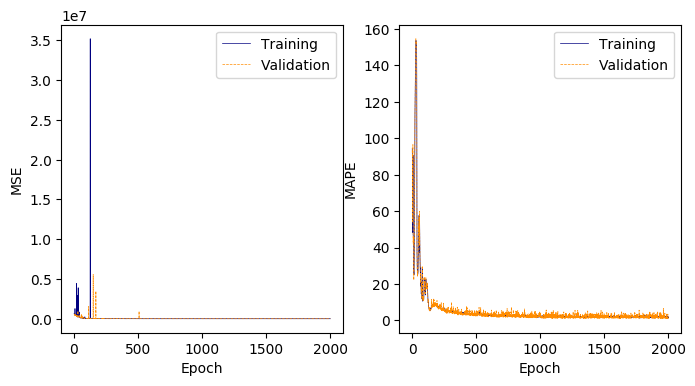

In [71]:
# Create a figure and 2 subplots.
fig, ax = plt.subplots(
    num = 'Learning',
    figsize = (8.0, 4.0),
    nrows = 1,
    ncols = 2
)

# Plot loss on the training data on the left subplot.
ax[0].plot(
    history.index + 1,
    history.loss,
    color = 'navy',
    linestyle = '-',
    linewidth = '0.5',
    marker = 'None',
    label = 'Training'
)

# Plot loss on the validation data on the right subplot.
ax[0].plot(
    history.index + 1,
    history.val_loss,
    color = 'darkorange',
    linestyle = '--',
    linewidth = '0.5',
    marker = 'None',
    label = 'Validation'
)

# Plot MAPE on the training data on the right subplot
ax[1].plot(
    history.index + 1,
    history.mean_absolute_percentage_error,
    color = 'navy',
    linestyle = '-',
    linewidth = '0.5',
    marker = 'None',
    label = 'Training'
)

# Plot MAPE on the validation data on the right subplot.
ax[1].plot(
    history.index + 1,
    history.val_mean_absolute_percentage_error,
    color = 'darkorange',
    linestyle = '--',
    linewidth = '0.5',
    marker = 'None',
    label = 'Validation'
)

# Set the y-axis scale to logarithmic on both subplots.
#for i in six.moves.range(2):
#    ax[i].set_yscale('log')
#try:
#    del i
#except (NameError, UnboundLocalError):
#    pass

# Set axis labels on the left subplot.
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')

# Set axis labels on the right subplot.
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MAPE')

# Set legends on the subplots.
for i in six.moves.range(2):
    ax[i].legend(loc = 'upper right')
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Save the figure
fig.savefig('neural_network_learning.pdf', bbox_inches = 'tight')

# Show the plots.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


**Računanje greške na testnom skupu podataka&hellip;**


(greška je prikazana kao lista `[MSE, MAE, MAPE]`)


Na cijelom skupu&hellip;


In [73]:
model.evaluate(x = num.test[features_index], y = num.test.l_0, verbose = 0)


[60.81301064392053, 2.668563587837733, 0.8788196818481314]

Po $ 5 \, \% $-tnim kvantilima&hellip;


In [74]:
# Display errors on 5 % quantiles.
for i in six.moves.range(int(l_0_quant.size) - 1):
    # Extract the indices of the `i`-th quantile.
    I = (num.test.l_0 >= l_0_quant[i]) & (num.test.l_0 < l_0_quant[i + 1])

    # Display the error on the `i`-th quantile.
    print(
        "{ind:2d}: {low:7.2f} -- {high:7.2f}".format(
            ind = i + 1,
            low = l_0_quant[i],
            high = l_0_quant[i + 1]
        )
    )
    display(
        model.evaluate(
            x = num.test.loc[I, features_index],
            y = num.test.loc[I, 'l_0'],
            verbose = 0
        )
    )
    print(str())

    # Free the memory.
    del I
try:
    del i
except (NameError, UnboundLocalError):
    pass


 1:   52.72 --   55.41


[2.7938953333122787, 1.6030490885749733, 2.954242461022432]


 2:   55.41 --   58.46


[0.21013112357080055, 0.383803083817845, 0.6749856051791692]


 3:   58.46 --   62.06


[0.7460795486279771, 0.7683322636850607, 1.2707517088699807]


 4:   62.06 --   66.20


[1.198940426731343, 0.9086085302593366, 1.410001508462969]


 5:   66.20 --   71.01


[1.0524414043823391, 0.9133551599346147, 1.3413062493979129]


 6:   71.01 --   76.74


[0.3097915034034407, 0.44180471580498365, 0.5971932657053888]


 7:   76.74 --   83.51


[0.6523435289448303, 0.6784917015486569, 0.8469325715500401]


 8:   83.51 --   91.80


[0.383984786206389, 0.5390546275177376, 0.6176857111138843]


 9:   91.80 --  102.00


[2.2420565571312223, 1.3577033876643188, 1.4076457591214409]


10:  102.00 --  114.76


[0.2789103202749787, 0.42305373715070355, 0.390233411637193]


11:  114.76 --  130.69


[0.5093966551042974, 0.5882236662080268, 0.48262521278026493]


12:  130.69 --  152.54


[0.6610838899997632, 0.6667628212395321, 0.47062470790368105]


13:  152.54 --  181.99


[1.4345216780280834, 0.9554397225234033, 0.5713026112121059]


14:  181.99 --  221.86


[2.878398624598761, 1.2741535420517005, 0.6332949720952327]


15:  221.86 --  282.86


[2.5954533224444347, 1.1663775966392154, 0.46500184293038405]


16:  282.86 --  381.22


[11.717705155527868, 2.619348233595326, 0.7985444626288724]


17:  381.22 --  541.76


[11.20878318357059, 2.612393627551953, 0.5760521386799059]


18:  541.76 --  861.51


[30.892803509641016, 4.37943435444826, 0.6397672318916134]


19:  861.51 -- 1714.84


[113.80043401449663, 8.172232465615616, 0.6737856726313747]


20: 1714.84 -- 5942.29


[1030.693054273925, 22.919649532696315, 0.7544164931905459]

**Grafički prikaz točnosti predviđanja&hellip;**


Na cijelom skupu&hellip;


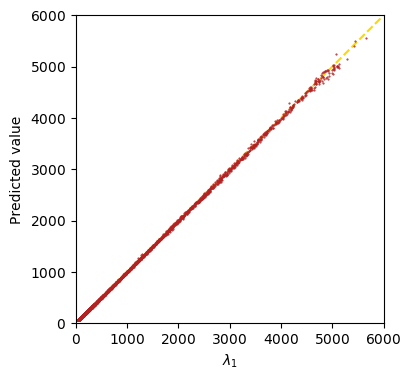

In [75]:
# Create a figure.
fig = plt.figure(num = 'Prediction error', figsize = (4.0, 4.0))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the subplot to equal.
ax.set_aspect('equal')

# Plot the identity line.
ax.plot(
    [l_0_quant[0], l_0_quant[-1]],
    [l_0_quant[0], l_0_quant[-1]],
    color = 'gold',
    linestyle = '--',
    marker = 'None'
)

# Plot lambda_0 prediction over true lambda_0.
try:
    ax.plot(
        num.test.l_0,
        K.get_value(
            model.predict(
                x = num.test[features_index],
                batch_size = 2048,
                verbose = 0
            )
        ),
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )
except (AttributeError):
    ax.plot(
        num.test.l_0,
        model.predict(
            x = num.test[features_index],
            batch_size = 2048,
            verbose = 0
        ),
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )

# Set axis labels.
ax.set_xlabel("$ \\lambda_{1} $")
ax.set_ylabel('Predicted value')

# Set ticks.
ax.set_xticks(ticks['l_0'])
ax.set_yticks(ticks['l_0'])

# Set tick labels.
ax.set_xticklabels(ticklabels['l_0'])
ax.set_yticklabels(ticklabels['l_0'])

# Set axis limits.
ax.set_xlim(lim['l_0'])
ax.set_ylim(lim['l_0'])

# Save the figure.
fig.savefig('neural_network_prediction.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


Na donjih $ 90 \, \% $&hellip;


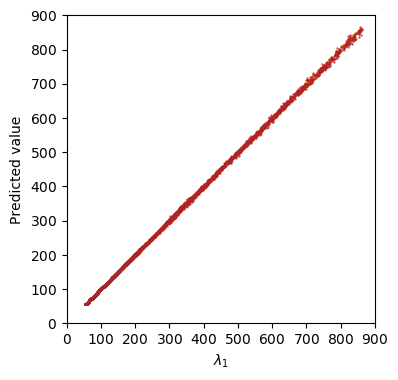

In [77]:
# Create a figure.
fig = plt.figure(num = 'Prediction error', figsize = (4.0, 4.0))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the subplot to equal.
ax.set_aspect('equal')

# Plot the identity line.
ax.plot(
    [l_0_quant[0], l_0_quant[-3] + 1.0e-8],
    [l_0_quant[0], l_0_quant[-3] + 1.0e-8],
    color = 'gold',
    linestyle = '--',
    marker = 'None'
)

# Plot lambda_0 prediction over true lambda_0.
try:
    ax.plot(
        num.test.loc[num.test.l_0 < l_0_quant[-3] + 1.0e-8, 'l_0'],
        K.get_value(
            model.predict(
                x = num.test.loc[
                    num.test.l_0 < l_0_quant[-3] + 1.0e-8,
                    features_index
                ],
                batch_size = 2048,
                verbose = 0
            )
        ),
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )
except (AttributeError):
    ax.plot(
        num.test.loc[num.test.l_0 < l_0_quant[-3] + 1.0e-8, 'l_0'],
        model.predict(
            x = num.test.loc[
                num.test.l_0 < l_0_quant[-3] + 1.0e-8,
                features_index
            ],
            batch_size = 2048,
            verbose = 0
        ),
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )

# Set axis labels.
ax.set_xlabel("$ \\lambda_{1} $")
ax.set_ylabel('Predicted value')

# Set ticks.
ax.set_xticks(ticks['l_0_90_pc'])
ax.set_yticks(ticks['l_0_90_pc'])

# Set tick labels.
ax.set_xticklabels(ticklabels['l_0_90_pc'])
ax.set_yticklabels(ticklabels['l_0_90_pc'])

# Set axis limits.
ax.set_xlim(lim['l_0_90_pc'])
ax.set_ylim(lim['l_0_90_pc'])

# Save the figure.
fig.savefig('neural_network_prediction_90_percent.pdf', bbox_inches = 'tight')

# Show the plot.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


### Zaključak <a class="anchor" id="nn-conclusion"></a>


Model neuronske mreže vrlo dobro predviđa najmanju svojstvenu vrijednost Laplaceovog operatora na trokutima. To znači da je poznavanje duljina stranica, veličina vanjskih kutova i singularnih vrijednosti duljina stranica i vanjskih kutova, na trokutima, dovoljno informacija da se relativno lako (aktivacijske funkcije su samo `ReLU` i multiplikativni inverz) izračuna tražena vrijednost. Kompleksnost ovakvog modela s porastom broja kutova raste linearno, no nije sigurno da bi ovakav model bio generalizabilan (za četverokute, peterokute&hellip;).


In [0]:
# Free the memory.
del num
del features_index
del model
del history


## Konvolucijska neuronska mreža <a class="anchor" id="convolutional-neural-network"></a>


Učitavanje podataka&hellip;


In [0]:
img = DataSet('imagination', DataSubSet.coordinates | DataSubSet.eigenvalues)


Konstruiranje indeksa stupaca s koordinatama vrhova&hellip;


In [0]:
coordinates = pd.Index(
    ['x_0', 'y_0', 'x_1', 'y_1', 'x_2', 'y_2'],
    dtype = str,
    copy = True
)


Konstruiranje [*NumPy*](https://numpy.org/) polja s granicama vizualiziranog pravokutnika&hellip;


In [0]:
bbox = np.array(
    [[-1.0, -1.0], [1.0, 1.0]],
    dtype = float,
    copy = True,
    order = 'C'
)


Definiranje rezolucije vizualizacije&hellip;


(izbriši `#` ispred linija

```Python
res = 128

with (
    open('models/convolutional_neural_network_resolution.txt', 'wt')
) as resolution_output:
    resolution_output.write("{r:d}\n".format(r = res))
try:
    del resolution_output
except (NameError, UnboundLocalError):
    pass
```

za stvarno definiranje i spremanje rezolucije respektivno)


In [0]:
# Define the resolution.
#res = 128

# Print the resolution to a file.
#with (
#    open('models/convolutional_neural_network_resolution.txt', 'wt')
#) as resolution_output:
#    resolution_output.write("{r:d}\n".format(r = res))
#try:
#    del resolution_output
#except (NameError, UnboundLocalError):
#    pass

# Read the resolution from a file.
res = -1
with (
    open('models/convolutional_neural_network_resolution.txt', 'rt')
) as resolution_input:
    res = int(resolution_input.readline().strip())
try:
    del resolution_input
except (NameError, UnboundLocalError):
    pass


Definiranje normalizacijskog faktora&hellip;


(izbriši `#` ispred linija

```Python
nf = 3.4641016151377545870548926830117447338856105076207612561116139589

with (
    open('models/convolutional_neural_network_normalisation_factor.txt', 'wt')
) as normalisation_factor_output:
    normalisation_factor_output.write("{f:.64f}\n".format(f = nf))
try:
    del normalisation_factor_output
except (NameError, UnboundLocalError):
    pass
```

za stvarno definiranje i spremanje normalizacijskog faktora respektivno)


In [0]:
# Define the normalisation factor.
#nf = 3.4641016151377545870548926830117447338856105076207612561116139589

# Print the normalisation factor to a file.
#with (
#    open('models/convolutional_neural_network_normalisation_factor.txt', 'wt')
#) as normalisation_factor_output:
#    normalisation_factor_output.write("{f:.64f}\n".format(f = nf))
#try:
#    del normalisation_factor_output
#except (NameError, UnboundLocalError):
#    pass

# Read the normalisation factor from a file.
nf = 0.0
with (
    open('models/convolutional_neural_network_normalisation_factor.txt', 'rt')
) as normalisation_factor_input:
    nf = float(normalisation_factor_input.readline().strip())
try:
    del normalisation_factor_input
except (NameError, UnboundLocalError):
    pass


Konstruiranje vizualizacija trokuta i ekstrahiranje ciljne varijable&hellip;


(izbriši&mdash;ili bolje, zakomentiraj&mdash;linije

```Python
if name != 'test':
    continue
```

ako se mreža treba trenirati, a ne učitati već istrenirana s vanjske memorije)


In [0]:
# Initialise the family of sets of triangles' visualisations to an empty
# dictionary.
X = dict()

# Initialise the target value to an empty dictionary.
l_0 = dict()

# Construct the sets of triangles' visualisations for each of the datasets
# (trainig, validation and testing).
for name, df in zip(['train', 'validation', 'test'], iter(img)):
    # Skip everything except the testing dataset.
    if name != 'test':
        continue

    # Initialise the set of visualisations to zeros.
    X.update(
        {
            name : np.zeros(
                (int(df.shape[0]), res, res),
                dtype = float,
                order = 'C'
            )
        }
    )

    # Iterate over the triangles and visualise them.
    for i in six.moves.range(int(df.shape[0])):
        visualise_triangle(
            df.loc[i, coordinates],
            bbox = bbox,
            m = res + 1,
            n = res + 1,
            out = X[name][i]
        )
    try:
        del i
    except (NameError, UnboundLocalError):
        pass

    # Normalise the visualisations by the normalisation factor.
    X[name] *= nf

    # Copy the target values.
    l_0.update({name : df.l_0.values.copy(order = 'C')})
try:
    del name
except (NameError, UnboundLocalError):
    pass
try:
    del df
except (NameError, UnboundLocalError):
    pass


In [0]:
# Free the memory.
del coordinates
del bbox
del nf


In [0]:
# Free the memory.
del img


In [88]:
# Free the memory.
gc.collect()


38589

**Konstruiranje modela konvolucijske neuronske mreže kao instance klase `keras.models.Sequential`&hellip;**


Arhitektura konvolucijske neuronske neuronske mreže inspirirana je modelom kojeg su razvili Mills, Spanner i Tamblyn u [[1]](#bib-Mills17), ali je zbog ograničenih resursa rezolucija ulaznih podataka reducirana na $ 128 \times 128 $, zbog čega je redukcijskih slojeva u neuronskoj mreži samo $ 6 $, a ne $ 7 $. Također, zbog manjka resursa mreža se trenira u samo $ 50 $ epoha pa će inicijalna brzina učenja u optimizaciji biti drugačija. Ostali hiperparametri (broj filtera, veličina jezgre i pomaka, aktivacijske funkcije&hellip;) isti su kao u originalnom modelu.


In [0]:
model = MST_CNN_sequential(input_shape = (res, res, 1), reductions = 6)
model.add(kl.Dense(units = 1, activation = 'linear', name = 'output'))


In [0]:
# Free the memory.
del res


In [91]:
# Free the memory.
gc.collect()


17

**Izgradnja konvolucijske neuronske mreže&hellip;**


In [0]:
model.compile(
    optimizer = MST_CNN_optimiser(),
    loss = 'mean_squared_error',
    metrics = ['mean_absolute_error', 'mean_absolute_percentage_error']
)


**Treniranje konvolucijske neuronske mreže&hellip;**


(izbriši `#` ispred linija

```Python
history = model.fit(
    x = X['train'][:, :, :, np.newaxis],
    y = l_0['train'],
    batch_size = 256,
    epochs = 50,
    validation_data = (X['validation'][:, :, :, np.newaxis], l_0['validation']),
    shuffle = True,
    verbose = 1,
    callbacks = [
        kc.TerminateOnNaN(),
        kc.ModelCheckpoint(
            'models/convolutional_neural_network.h5',
            monitor = 'val_loss',
            save_best_only = True,
            mode = 'min',
            period = 1
        )
    ]
)

pd.DataFrame(history.history).to_csv(
    'models/convolutional_neural_network_history.csv',
    sep = ',',
    float_format = "%.8f",
    header = True,
    index = True
)
```

za stvarno treniranje i spremanje modela, i spremanje povijesti učenja, respektivno)


In [0]:
# Train the model.
#history = model.fit(
#    x = X['train'][:, :, :, np.newaxis],
#    y = l_0['train'],
#    batch_size = 256,
#    epochs = 50,
#    validation_data = (X['validation'][:, :, :, np.newaxis], l_0['validation']),
#    shuffle = True,
#    verbose = 1,
#    callbacks = [
#        kc.TerminateOnNaN(),
#        kc.ModelCheckpoint(
#            'models/convolutional_neural_network.h5',
#            monitor = 'val_loss',
#            save_best_only = True,
#            mode = 'min',
#            period = 1
#        )
#    ]
#)

# Save the history as a CSV table.
#pd.DataFrame(history.history).to_csv(
#    'models/convolutional_neural_network_history.csv',
#    sep = ',',
#    float_format = "%.8f",
#    header = True,
#    index = True
#)

# Delete the model and the history.
del model
#del history

# Load the model with the best weights.
model = km.load_model('models/convolutional_neural_network.h5')

# Load the history.
history = pd.read_csv(
    'models/convolutional_neural_network_history.csv',
    header = 0,
    index_col = 0
)


**Prikaz učenja konvolucijske neuronske mreže&hellip;**


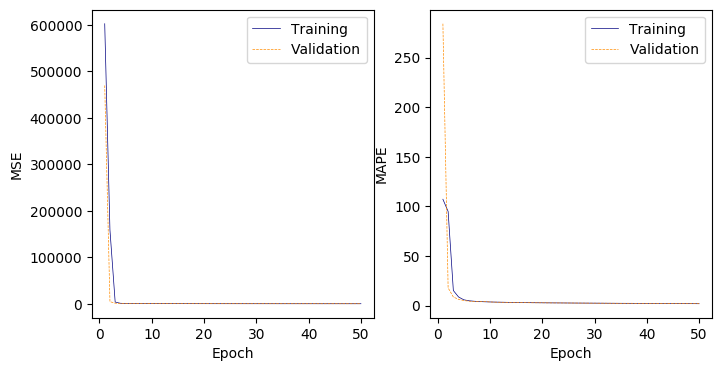

In [94]:
# Create a figure and 2 subplots.
fig, ax = plt.subplots(
    num = 'Learning',
    figsize = (8.0, 4.0),
    nrows = 1,
    ncols = 2
)

# Plot loss on the training data on the left subplot.
ax[0].plot(
    history.index + 1,
    history.loss,
    color = 'navy',
    linestyle = '-',
    linewidth = '0.5',
    marker = 'None',
    label = 'Training'
)

# Plot loss on the validation data on the right subplot.
ax[0].plot(
    history.index + 1,
    history.val_loss,
    color = 'darkorange',
    linestyle = '--',
    linewidth = '0.5',
    marker = 'None',
    label = 'Validation'
)

# Plot MAPE on the training data on the right subplot
ax[1].plot(
    history.index + 1,
    history.mean_absolute_percentage_error,
    color = 'navy',
    linestyle = '-',
    linewidth = '0.5',
    marker = 'None',
    label = 'Training'
)

# Plot MAPE on the validation data on the right subplot.
ax[1].plot(
    history.index + 1,
    history.val_mean_absolute_percentage_error,
    color = 'darkorange',
    linestyle = '--',
    linewidth = '0.5',
    marker = 'None',
    label = 'Validation'
)

# Set the y-axis scale to logarithmic on both subplots.
#for i in six.moves.range(2):
#    ax[i].set_yscale('log')
#try:
#    del i
#except (NameError, UnboundLocalError):
#    pass

# Set axis labels on the left subplot.
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')

# Set axis labels on the right subplot.
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MAPE')

# Set legends on the subplots.
for i in six.moves.range(2):
    ax[i].legend(loc = 'upper right')
try:
    del i
except (NameError, UnboundLocalError):
    pass

# Save the figure
fig.savefig('convolutional_neural_network_learning.pdf', bbox_inches = 'tight')

# Show the plots.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


**Računanje greške na testnom skupu podataka&hellip;**


(greška je prikazana kao lista `[MSE, MAE, MAPE]`)


Na cijelom skupu&hellip;


In [96]:
model.evaluate(x = X['test'][:, :, :, np.newaxis], y = l_0['test'], verbose = 0)


[381.48342798614505, 6.744035605875651, 1.8378611038208008]

Po $ 5 \, \% $-tnim kvantilima&hellip;


In [97]:
# Display errors on 5 % quantiles.
for i in six.moves.range(int(l_0_quant.size) - 1):
    # Extract the indices of the `i`-th quantile.
    I = (l_0['test'] >= l_0_quant[i]) & (l_0['test'] < l_0_quant[i + 1])

    # Display the error on the `i`-th quantile.
    print(
        "{ind:2d}: {low:7.2f} -- {high:7.2f}".format(
            ind = i + 1,
            low = l_0_quant[i],
            high = l_0_quant[i + 1]
        )
    )
    display(
        model.evaluate(
            x = X['test'][I, :, :, np.newaxis],
            y = l_0['test'][I],
            verbose = 0
        )
    )
    print(str())

    # Free the memory.
    del I
try:
    del i
except (NameError, UnboundLocalError):
    pass


 1:   52.72 --   55.41


[0.9841793130238851, 0.8357150170008342, 1.5331211071014403]


 2:   55.41 --   58.46


[1.4120766280492147, 0.9419725840886434, 1.650318559328715]


 3:   58.46 --   62.06


[1.2736799863179524, 0.905025476137797, 1.4999823780059816]


 4:   62.06 --   66.20


[1.4449256496429443, 0.9633012653986613, 1.4998260189692179]


 5:   66.20 --   71.01


[2.0019648933410643, 1.1563495073318482, 1.6865964895884196]


 6:   71.01 --   76.74


[1.6070651423136393, 1.0367494705518088, 1.4042343165079754]


 7:   76.74 --   83.51


[2.108557476043701, 1.194341736157735, 1.4893931465148926]


 8:   83.51 --   91.80


[3.320472432454427, 1.3571079619725546, 1.5475147558848064]


 9:   91.80 --  102.00


[4.313917011260986, 1.6208292547861736, 1.67374933052063]


10:  102.00 --  114.76


[6.1821677780151365, 1.9957972405751547, 1.8423070570627849]


11:  114.76 --  130.69


[10.298711756388347, 2.603285341262817, 2.120873149236043]


12:  130.69 --  152.54


[16.58108072916667, 3.387588545481364, 2.4063391507466636]


13:  152.54 --  181.99


[22.83521603393555, 3.958597028096517, 2.3786402219136558]


14:  181.99 --  221.86


[29.356342290242512, 4.386995688120524, 2.1815890725453695]


15:  221.86 --  282.86


[40.99375219726563, 5.105767737070719, 2.0292505343755085]


16:  282.86 --  381.22


[78.63127817789713, 7.056828002929688, 2.139578145980835]


17:  381.22 --  541.76


[181.68679622395834, 10.899855997721355, 2.405205771128337]


18:  541.76 --  861.51


[334.44915543619794, 14.015522918701173, 2.1039826278686524]


19:  861.51 -- 1714.84


[526.22452734375, 16.85933221435547, 1.3768550160725912]


20: 1714.84 -- 5942.29


[6363.9650442708335, 54.59974247233073, 1.787861053466797]

**Grafički prikaz točnosti predviđanja&hellip;**


Na cijelom skupu&hellip;


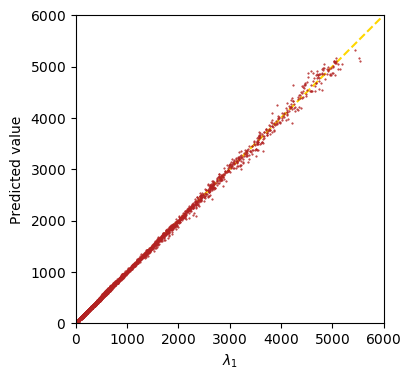

In [98]:
# Create a figure.
fig = plt.figure(num = 'Prediction error', figsize = (4.0, 4.0))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the subplot to equal.
ax.set_aspect('equal')

# Plot the identity line.
ax.plot(
    [l_0_quant[0], l_0_quant[-1]],
    [l_0_quant[0], l_0_quant[-1]],
    color = 'gold',
    linestyle = '--',
    marker = 'None'
)

# Plot lambda_0 prediction over true lambda_0.
try:
    ax.plot(
        l_0['test'],
        K.get_value(
            model.predict(
                x = X['test'][:, :, :, np.newaxis],
                batch_size = 2048,
                verbose = 0
            )
        ),
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )
except (AttributeError):
    ax.plot(
        l_0['test'],
        model.predict(
            x = X['test'][:, :, :, np.newaxis],
            batch_size = 2048,
            verbose = 0
        ),
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )

# Set axis labels.
ax.set_xlabel("$ \\lambda_{1} $")
ax.set_ylabel('Predicted value')

# Set ticks.
ax.set_xticks(ticks['l_0'])
ax.set_yticks(ticks['l_0'])

# Set tick labels.
ax.set_xticklabels(ticklabels['l_0'])
ax.set_yticklabels(ticklabels['l_0'])

# Set axis limits.
ax.set_xlim(lim['l_0'])
ax.set_ylim(lim['l_0'])

# Save the figure.
fig.savefig(
    'convolutional_neural_network_prediction.pdf',
    bbox_inches = 'tight'
)

# Show the plot.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


Na donjih $ 90 \, \% $&hellip;


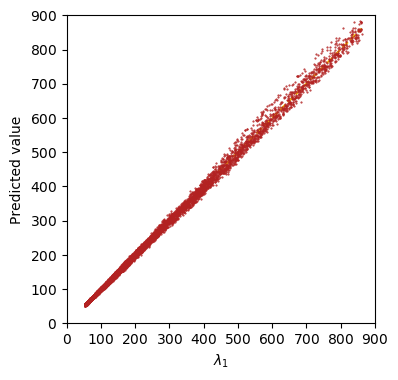

In [100]:
# Create a figure.
fig = plt.figure(num = 'Prediction error', figsize = (4.0, 4.0))

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the subplot to equal.
ax.set_aspect('equal')

# Plot the identity line.
ax.plot(
    [l_0_quant[0], l_0_quant[-3] + 1.0e-8],
    [l_0_quant[0], l_0_quant[-3] + 1.0e-8],
    color = 'gold',
    linestyle = '--',
    marker = 'None'
)

# Plot lambda_0 prediction over true lambda_0.
try:
    ax.plot(
        l_0['test'][l_0['test'] < l_0_quant[-3] + 1.0e-8],
        K.get_value(
            model.predict(
                x = X['test'][
                    l_0['test'] < l_0_quant[-3] + 1.0e-8,
                    :,
                    :,
                    np.newaxis
                ],
                batch_size = 2048,
                verbose = 0
            )
        ),
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )
except (AttributeError):
    ax.plot(
        l_0['test'][l_0['test'] < l_0_quant[-3] + 1.0e-8],
        model.predict(
            x = X['test'][
                l_0['test'] < l_0_quant[-3] + 1.0e-8,
                :,
                :,
                np.newaxis
            ],
            batch_size = 2048,
            verbose = 0
        ),
        color = 'firebrick',
        linestyle = 'None',
        marker = '.',
        ms = 1
    )

# Set axis labels.
ax.set_xlabel("$ \\lambda_{1} $")
ax.set_ylabel('Predicted value')

# Set ticks.
ax.set_xticks(ticks['l_0_90_pc'])
ax.set_yticks(ticks['l_0_90_pc'])

# Set tick labels.
ax.set_xticklabels(ticklabels['l_0_90_pc'])
ax.set_yticklabels(ticklabels['l_0_90_pc'])

# Set axis limits.
ax.set_xlim(lim['l_0_90_pc'])
ax.set_ylim(lim['l_0_90_pc'])

# Save the figure.
fig.savefig(
    'convolutional_neural_network_prediction_90_percent.pdf',
    bbox_inches = 'tight'
)

# Show the plot.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


### Zaključak <a class="anchor" id="cnn-conclusion"></a>


Konvolucijska neuronska mreža također solidno predviđa najmanju svojstvenu vrijednost Laplaceovog operatora na trokutima. Najveća prednost koju ovaj model ima nad ranije promatranima je njegova generalizabilnost&mdash;za proučavanje mnogokutova s više kutova (četverokuti, peterokuti&hellip;) ne raste nužno kompleksnost modela, kao što se pojavljuje više koordinata karakterističnih točaka za polinome ili više numeričkih vrijednosti za obične neuronske mreže. Međutim, za $ n $-terokute za veliki $ n \in \mathbb{N} $ možda rezolucija $ 128 \times 128 $ na pravokutniku $ \left[ {- 1} , 1 \right] \times \left[ {- 1} , 1 \right] $ nije dovoljna pa bi se kompleksnost modela tada možda ipak trebala povećati.

Također, generalizirani model konvolucijske neuronske mreže, ako bi bio dobar, mogao bi istovremeno predviđati najmanju svojstvenu vrijednost na svim $ n $-terokutovima za $ n \in \left\{ 3 , 4 , \dotsc , m \right\} $ za neki $ m \in \mathbb{N} $, $ m \geq 3 $. Kod prethodno promatranih modela za takvu generalizaciju potrebne su konvencije o postavljanju nepravih vrhova na stranice (na primjer, na najdulju stranicu umetnemo kao novi vrh njezino polovište; postupak ponavljamo dok broj vrhova nije dovoljan) ili povećani skup podataka (s više izbora o umetanju nepravih vrhova).


In [0]:
# Free the memory.
del X
del l_0
del model
del history


## Minimizacija $ \lambda_{1} $ za fiksni opseg trokuta <a class="anchor" id="fixed-circumference-lambda-minimisation"></a>


### Manipulacija trokutima <a class="anchor" id="min-triangles-manipulation"></a>


Definiranje pomoćnih funkcija za manipulaciju trokutima (pretprocesija za modele koja je inače napisana u programskom jeziku [*C*](https://en.cppreference.com/w/c/header))&hellip;


In [0]:
def correct_orientation (T):
    """
    Correct the orientation of the enumeration of vertices of a triangle.

    Returns
    =======
    (6,) array.
        The array of the coordinates of vertices of the triangle such that the
        first vertex is the one with the minimal y-coordinate (and the maximal
        x-coordinate if there are ties) and whose vertices are enumerated
        positively oriented.

    Notes
    =====
    The original array `T` must be of shape `(6,)`.  The original array and the
    resulting array represent a triangle by defining its vertices' coordinates
    as `[x_0, y_0, x_1, y_1, x_2, y_2]`, where (`x_i`, `y_i`) are coordinates of
    the `i`-th vertex.

    """

    # Initialise the index of the correctly first vertex's x-coordinate to 0.
    v = 0

    # Find the index of the correctly first vertex's x-coordinate.
    for i in six.moves.range(2, 5, 2):
        if T[i + 1] < T[v + 1] or (T[i + 1] == T[v + 1] and T[i] < T[v]):
            v = i
    try:
        del i
    except (NameError, UnboundLocalError):
        pass

    # Construct the array of the coordinates so that the correctly first vertex
    # is the first vertex.
    T = np.array(
        np.roll(T, -v) if v else T,
        dtype = float,
        copy = True,
        order = 'C'
    )

    # Free the memory.
    del v

    # If necessary, permute the coordinates so that they are enumerated
    # positively oriented.
    if (T[0] - T[4]) * (T[3] - T[5]) - (T[2] - T[4]) * (T[1] - T[5]) < 0:
        T[2:5:2] = T[4:1:-2]
        T[3:6:2] = T[5:2:-2]

    # Return the array of coordinates.
    return T


In [0]:
def edges_lengths (T):
    """
    Compute the lengths of edges of a triangle.

    Returns
    =======
    a : float
        Length of the edge from the first to the second vertex.

    b : float
        Length of the edge from the second to the third vertex.

    c : float
        Length of the edge from the third to the first vertex.

    Notes
    =====
    The array `T` must be of shape `(6,)`.  The array represents a triangle by
    defining its vertices' coordinates as `[x_0, y_0, x_1, y_1, x_2, y_2]`,
    where (`x_i`, `y_i`) are coordinates of the `i`-th vertex.

    """

    return (
        math.sqrt((T[2] - T[0]) ** 2 + (T[3] - T[1]) ** 2),
        math.sqrt((T[4] - T[2]) ** 2 + (T[5] - T[3]) ** 2),
        math.sqrt((T[0] - T[4]) ** 2 + (T[1] - T[5]) ** 2)
    )


In [0]:
def outer_angles (a, b, c):
    """
    Compute the outer angles of a triangle of sides `a`, `b`, `c`.

    Returns
    =======
    alpha : float
        The outer angle at the vertex opposite of the side `a`.

    beta : float
        The outer angle at the vertex opposite of the side `b`.

    gamma : float
        The outer angle at the vertex opposite of the side `c`.

    """

    # Initialise the angles to zeros.
    alpha = 0.0
    beta = 0.0
    gamma = 0.0

    # If `a` is the largest side, compute the angles.
    if a >= b and a >= c:
        # Conduct the first steps to compute the inner angle `alpha` using the
        # cosine law.

        # Initialise the quotient for computing the inner angle `alpha` to NaN.
        Q = float('nan')

        # If no side is of length 0 or infinite, compute the quotient for
        # computing the inner angle `alpha` to NaN.
        if b and c and not (math.isinf(b) or math.isinf(c) or math.isinf(a)):
            Q = (b ** 2 + c ** 2 - a ** 2) / (2.0 * b * c)

        # If `Q` is in the range [-1, 1], compute the angles.
        if Q >= -1.0 and Q <= 1.0:
            # Compute the inner angle `alpha` using the cosine law.
            alpha = math.acos(Q)

            # Compute `sin(alpha)`.
            sin_alpha = math.sin(alpha)

            # Compute the inner angles `beta` and `gamma` using the sine law if
            # `a` is of finite length.
            if not math.isinf(a):
                beta = math.asin(max(min(b / a * sin_alpha, 1.0), -1.0))
                gamma = math.asin(max(min(c / a * sin_alpha, 1.0), -1.0))

            # Free the memory.
            del sin_alpha

        # Compute the outer angles by subtracting the inner angles from pi.
        alpha = max(min(math.pi - alpha, math.pi), 0.0)
        beta = max(min(math.pi - beta, math.pi), 0.0)
        gamma = max(min(math.pi - gamma, math.pi), 0.0)

        # Free the memory.
        del Q
    # Otherwise, use the inner angles of the triangle of sides `b`, `c`, `a`.
    else:
        beta, gamma, alpha = outer_angles(b, c, a)

    # Return the computed angles.
    return (alpha, beta, gamma)


In [0]:
def sort_edges_angles (a, b, c, alpha, beta, gamma):
    """
    Sort the lengths of edges and the outer angles of a triangle.

    The lengths of edges are sorted descendingly, while the outer angles are
    sorted ascendingly.  It is believed that the outer angle `alpha` is at the
    vertex oposite of the side `a`, the outer angle `beta` is at the vertex
    oppostie of the side `b` and the outer angle `gamma` is at the vertex
    opposite of the side `c` (the angles are not compared, they are sorted
    parallel to the sorting of the lengths of edges).

    Returns
    =======
    a_ : float
        The longest side.

    c_ : float
        The second longest/second shortest side.

    b_ : float
        The shortest side.

    alpha_ : float
        The smallest outer angle.

    gamma_ : float
        The second smallest/second largest outer angle.

    beta_ : float
        The largest outer angle.

    """

    # Sort the lengths of edges and the outer angles.
    if a < b:
        a, b = (b, a)
        alpha, beta = (beta, alpha)
    if a < c:
        a, c = (c, a)
        alpha, gamma = (gamma, alpha)
    if b > c:
        c, b = (b, c)
        gamma, beta = (beta, gamma)

    # Return the sorted values.
    return (a, c, b, alpha, gamma, beta)


In [0]:
def characteristic (a, c, b, alpha, gamma, beta, norm = False):
    """
    Compute the coordinates of the characteristic point of a triangle.

    If `norm` is true, it is assumed that the longest side of the triangle is of
    length 1 (that the triangle is of diameter 1).  Otherwise additional
    computation is done.

    The lengths of edges `a`, `c`, `b` should be sorted descendingly, while the
    outer angles `alpha`, `gamma`, `beta` should be sorted ascendingly.  Use the
    function `sort_edges_angles` to ensure this.

    Returns
    =======
    x : float
        The x-coordinate of the characteristic point.

    y : float
        The y-coordinate of the characteristic point.

    """

    # If the triengles edges are not normed, divide `b` by `a`.
    if not norm:
        b /= a

    # Compute and return the characteristic point's coordinates.
    return (0.5 * b * math.cos(gamma), b * math.sin(gamma))


In [0]:
def svd (x, y, z):
    """
    Return the singular values of a triangle.

    If `x`, `y` and `z` are the lengths of edges of a triangle, the singular
    values of the lengths of edges are returned.  If `x`, `y` and `z` are the
    outer angles of a triangle, the singular values of the outer angles are
    returned.

    Returns
    =======
    (3,) array
        The singular values sorted descendingly.

    """

    # Construct an auxiliary matrix of the unoriented representation of the
    # array `[x, y, z]`.
    A = np.array(
        [
            [x, y, z],
            [z, y, x],
            [y, z, x],
            [x, z, y],
            [z, x, y],
            [y, x, z]
        ],
        dtype = float,
        copy = True,
        order = 'C'
    )

    # Compute the singular values of the matrix `A`.  Those close to 0 set to
    # 0 sharp.
    sv = np.linalg.svd(A, full_matrices = False, compute_uv = False)
    #sv[np.isclose(1.0, 1.0 + sv)] = 0.0

    # Free the memory.
    del A

    # Sort the singular values descendingly.
    sv = np.array(
        np.flip(np.sort(sv.ravel())),
        dtype = float,
        copy = True,
        order = 'C'
    )

    # Return the computed singular values.
    return sv


In [0]:
def centralise (T, a, b, c):
    """
    Centralise a triangle so that its incircle's center is at (0, 0).

    Returns
    =======
    (6,) array
        Coordinates of the triangle constructed by translating the original
        triangel `T` so that its incircle's center is at (0, 0).

    Notes
    =====
    The original array `T` must be of shape `(6,)`.  The original array and the
    resulting array represent a triangle by defining its vertices' coordinates
    as `[x_0, y_0, x_1, y_1, x_2, y_2]`, where (`x_i`, `y_i`) are coordinates of
    the `i`-th vertex.  It is believed that `a`, `b`, `c` are the lengths of the
    triangle's edges so that `a` spans from (`x_0`, `y_0`) to (`x_1`, `y_1`),
    `b` spans from (`x_1`, `y_1`) to (`x_2`, `y_2`) and `c` spans from
    (`x_2`, `y_2`) to (`x_0`, `y_0`).

    """

    # Compute the circumference of the triangle.
    C = a + b + c

    # Compute the coordinates of the incircle's center.
    x = (b * T[0] + c * T[2] + a * T[4]) / C
    y = (b * T[1] + c * T[3] + a * T[5]) / C

    # Free the memory.
    del C

    # Construct a new triangle by translating the original triangle.
    T = np.array(
        [T[0] - x, T[1] - y, T[2] - x, T[3] - y, T[4] - x, T[5] - y],
        dtype = float,
        copy = True,
        order = 'C'
    )

    # Free the memory.
    del x
    del y

    # Return the newly constructed triangle.
    return T


In [0]:
def construct (a, b, c, alpha, beta, gamma):
    """
    Construct a triangle with defined lengths of edges and outer angles.

    Returns
    =======
    (6,) array
        Coordinates of the triangle.  It is guaranteed that the triangle's
        incircle's center is at (0, 0) (up to a numerical precision).

    Notes
    =====
    The resulting array represents a triangle by defining its vertices'
    coordinates as `[x_0, y_0, x_1, y_1, x_2, y_2]`, where (`x_i`, `y_i`) are
    coordinates of the `i`-th vertex.

    """

    # Initialise the coordinates to zeros.
    T = np.zeros(tuple([6]), dtype = float, order = 'C')

    # Construct a triangle whose one sides lies on the negative part of the
    # x-axis and ends in the origin, and whose third vertex has a non-negative
    # y-coordinate.
    T[0] = -c
    T[4] = math.cos(beta) * a
    T[5] = math.sin(beta) * a

    # Compute a random angle in the interval [0, 2 * pi).
    phi = 2.0 * random.random() * math.pi

    # Compute the cosine and the sine of the angle.
    cos_phi = math.cos(phi)
    sin_phi = math.sin(phi)

    # Rotate the triangle around the origin by the angle `phi`.
    for i in six.moves.range(0, 5, 2):
        T[i], T[i + 1] = (
            cos_phi * T[i] - sin_phi * T[i + 1],
            sin_phi * T[i] + cos_phi * T[i + 1]
        )
    try:
        del i
    except (NameError, UnboundLocalError):
        pass

    # Free the memory.
    del phi

    # Centralise the triangle using the `centralise` function.
    T = centralise(T, a, b, c)

    # Return the constructed triangle.
    return T


### Učitavanje modela <a class="anchor" id="min-models-loading"></a>


**Učitavanje polinoma&hellip;**


In [0]:
# Load the models.
polynomial_4 = jl.load('models/polynomial_4.gz')
polynomial_5 = jl.load('models/polynomial_5.gz')

# Construct the functions to create polynomial terms.
polynomial_terms_4 = polynomial_terms_creator(4)
polynomial_terms_5 = polynomial_terms_creator(5)


**Učitavanje neuronske mreže&hellip;**


In [0]:
# Load the model.
nn = km.load_model(
    'models/neural_network.h5',
    custom_objects = {'relu_mult_inv' : relu_mult_inv}
)

# Load the features' mean and standard deviation for normalisation.
X_mean = np.load('models/neural_network_features_mean.npy')
X_std = np.load('models/neural_network_features_std.npy')


**Učitavanje konvolucijske neuronske mreže&hellip;**


In [0]:
# Load the model.
cnn = km.load_model('models/convolutional_neural_network.h5')

# Load the resolution of the visualisations for the convolutional neural
# network.
res = -1
with (
    open('models/convolutional_neural_network_resolution.txt', 'rt')
) as resolution_input:
    res = int(resolution_input.readline().strip())
try:
    del resolution_input
except (NameError, UnboundLocalError):
    pass

# Load the normalisation factor of the visualisations for the convolutional
# neural network.
nf = 0.0
with (
    open('models/convolutional_neural_network_normalisation_factor.txt', 'rt')
) as normalisation_factor_input:
    nf = float(normalisation_factor_input.readline().strip())
try:
    del normalisation_factor
except (NameError, UnboundLocalError):
    pass


### Minimizacija funkcijom [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) <a class="anchor" id="min-minimisation-using-scipy-optimize-minimize"></a>


Konstruiranje funkcija za provjeru vrijednosti (parametar `constraints`) u funkciji [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)&hellip;


In [0]:
def minimal_edge (T):
    """
    Returns the length of the shortest side of a triangle.

    Notes
    =====
    The array `T` must be of shape `(6,)`.  The array represents a triangle by
    defining its vertices' coordinates as `[x_0, y_0, x_1, y_1, x_2, y_2]`,
    where (`x_i`, `y_i`) are coordinates of the `i`-th vertex.

    """

    return min(edges_lengths(T))

def minimal_outer_angle (T):
    """
    Returns the minimal outer angle of a triangle.

    Notes
    =====
    The array `T` must be of shape `(6,)`.  The array represents a triangle by
    defining its vertices' coordinates as `[x_0, y_0, x_1, y_1, x_2, y_2]`,
    where (`x_i`, `y_i`) are coordinates of the `i`-th vertex.

    """

    return min(outer_angles(*edges_lengths(T)))

def maximal_outer_angle (T):
    """
    Returns the absolute difference of a triangle's maximal outer angle and pi.

    Notes
    =====
    The array `T` must be of shape `(6,)`.  The array represents a triangle by
    defining its vertices' coordinates as `[x_0, y_0, x_1, y_1, x_2, y_2]`,
    where (`x_i`, `y_i`) are coordinates of the `i`-th vertex.

    """

    return abs(max(outer_angles(*edges_lengths(T))) - math.pi)

def circumference_difference (T, C):
    """
    Returns the absolute difference of a triangle's circumference and a target circumference.

    Notes
    =====
    The array `T` must be of shape `(6,)`.  The array represents a triangle by
    defining its vertices' coordinates as `[x_0, y_0, x_1, y_1, x_2, y_2]`,
    where (`x_i`, `y_i`) are coordinates of the `i`-th vertex.

    The target circumference `C` should be a strictly positive real number.

    """

    return abs(sum(edges_lengths(T)) - C)


Definiranje funkcije za minimizaciju (parametar `fun`) u funkciji [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) modelom linearne regresije&hellip;


In [0]:
def polynomial_objective (T, deg = 4):
    """
    Approximate the minimal eigenvalue of Dirichlet Laplacian on a triangle.

    The eigenvalue is approximated using one of the polynomial models.  The
    degree of the polynomial is set with the parameter `deg`.

    Notes
    =====
    The array `T` must be of shape `(6,)`.  The array represents a triangle by
    defining its vertices' coordinates as `[x_0, y_0, x_1, y_1, x_2, y_2]`,
    where (`x_i`, `y_i`) are coordinates of the `i`-th vertex.

    """

    # Correct the orientation of the enumeration of vertices.
    T = correct_orientation(T)

    # Compute the lengths of edges of the triangle.
    a, b, c = edges_lengths(T)

    # Compute the diameter of the triangle, i. e. the length of its longest
    # side.
    d = max(a, b, c)

    # Normalise the triangle's edges by dividing them by `d`.
    a /= d
    b /= d
    c /= d

    # Compute the outer angles of the triangle.
    alpha, beta, gamma = outer_angles(a, b, c)

    # Sort the lengths of edges and the outer angles.
    a, c, b, alpha, gamma, beta = sort_edges_angles(a, b, c, alpha, beta, gamma)

    # Compute the coordinates of the characteristic point of the triangle.
    x, y = characteristic(a, c, b, alpha, gamma, beta, norm = True)

    # Free the memory.
    del a
    del b
    del c
    del alpha
    del beta
    del gamma

    # Approximate the minimal eigenvalue of the Dirichlet Laplacian on the
    # triangle.
    l_0 = float(
        d ** -2 * (
            polynomial_4.predict(
                np.array(
                    [polynomial_terms_4(x, y)],
                    dtype = float,
                    copy = True,
                    order = 'C'
                )
            ).ravel() if deg == 4 else polynomial_5.predict(
                np.array(
                    [polynomial_terms_5(x, y)],
                    dtype = float,
                    copy = True,
                    order = 'C'
                )
            ).ravel() if deg == 5 else float('nan')
        ) ** -1
    )

    # Free the memory.
    del d
    del x
    del y

    # Return the approximation of the minimal eigenvalue of the Dirichlet
    # Laplacian on the triangle.
    return l_0


In [0]:
# Define objective functions for polynomials as partial functions of the
# `polynomial_objective` function.
polynomial_4_objective = functools.partial(polynomial_objective, deg = 4)
polynomial_5_objective = functools.partial(polynomial_objective, deg = 5)


Definiranje funkcije za minimizaciju (parametar `fun`) u funkciji [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) modelom neuronske mreže&hellip;


In [0]:
def nn_objective (T):
    """
    Approximate the minimal eigenvalue of Dirichlet Laplacian on a triangle.

    The eigenvalue is approximated using the neural network.

    Notes
    =====
    The array `T` must be of shape `(6,)`.  The array represents a triangle by
    defining its vertices' coordinates as `[x_0, y_0, x_1, y_1, x_2, y_2]`,
    where (`x_i`, `y_i`) are coordinates of the `i`-th vertex.

    """

    # Correct the orientation of the enumeration of vertices.
    T = correct_orientation(T)

    # Compute the diameter of the triangle, i. e. the length of its longest
    # side.
    d = max(edges_lengths(T))

    # Normalise the triangle so that its diameter equals 1.
    T /= d

    # Compute the lengths of edges of the normalised triangle.
    a, b, c = edges_lengths(T)

    # Compute the outer angles of the triangle.
    alpha, beta, gamma = outer_angles(a, b, c)

    # Compute the singular values of the lengths of edges and of the outer
    # angles of the (normalised) triangle.
    sv_edges = svd(a, b, c)
    sv_angles = svd(alpha, beta, gamma)

    # Sort the lengths of edges and the outer angles.
    a, c, b, alpha, gamma, beta = sort_edges_angles(a, b, c, alpha, beta, gamma)

    # Approximate the minimal eigenvalue of the Dirichlet Laplacian on the
    # triangle.
    l_0 = float(
        d ** -2 *
        nn.predict(
            np.array(
                [
                    (
                        [
                            c,
                            b,
                            alpha,
                            gamma,
                            beta,
                            sv_edges[0],
                            sv_edges[1],
                            sv_angles[1]
                        ] - X_mean
                    ) / X_std
                ],
                dtype = float,
                copy = True,
                order = 'C'
            ),
            verbose = 0
        ).ravel()
    )

    # Free the memory.
    del a
    del b
    del c
    del alpha
    del beta
    del gamma
    del sv_edges
    del sv_angles
    del d

    # Return the approximation of the minimal eigenvalue of the Dirichlet
    # Laplacian on the triangle.
    return l_0


Definiranje funkcije za minimizaciju (parametar `fun`) u funkciji [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) modelom konvolucijske neuronske mreže&hellip;


In [0]:
def cnn_objective (T):
    """
    Approximate the minimal eigenvalue of Dirichlet Laplacian on a triangle.

    The eigenvalue is approximated using the convolutional neural network.

    Notes
    =====
    The array `T` must be of shape `(6,)`.  The array represents a triangle by
    defining its vertices' coordinates as `[x_0, y_0, x_1, y_1, x_2, y_2]`,
    where (`x_i`, `y_i`) are coordinates of the `i`-th vertex.

    """

    # Correct the orientation of the enumeration of vertices.
    T = correct_orientation(T)

    # Compute the diameter of the triangle, i. e. the length of its longest
    # side.
    d = max(edges_lengths(T))

    # Normalise the triangle so that its diameter equals 1.
    T /= d

    # Compute the lengths of edges of the normalised triangle.
    a, b, c = edges_lengths(T)

    # Approximate the minimal eigenvalue of the Dirichlet Laplacian on the
    # triangle.
    l_0 = float(
        d ** -2 *
        cnn.predict(
            np.array(
                [
                    nf *
                    visualise_triangle(
                        centralise(T, a, b, c),
                        bbox = [[-1.0, -1.0], [1.0, 1.0]],
                        m = res + 1,
                        n = res + 1
                    )[:, :, np.newaxis]
                ],
                dtype = float,
                copy = True,
                order = 'C'
            ),
            verbose = 0
        ).ravel()
    )

    # Free the memory.
    del a
    del b
    del c
    del d

    # Return the approximation of the minimal eigenvalue of the Dirichlet
    # Laplacian on the triangle.
    return l_0


Definiranje funkcije za kreiranje inicijalnog trokuta&hellip;


In [0]:
def initial_guess (
    min_edge = 0.2,
    max_edge = 2.0,
    min_angle = 0.1 * math.pi,
    max_angle = 0.9 * math.pi
):
    """
    Create a triangle by defining its vertices.

    Triangles will be generated until the minimal edge is at least `min_edge`,
    the maximal edge does not exceed `max_edge`, the minimal outer angle is at
    least `min_angle` and the maximal outer angle does not exceed `max_angle`.

    Returns
    =======
    (6,) array
        The array of the coordinates of vertices of the triangle.

    Notes
    =====
    The resulting array represents a triangle by defining its vertices'
    coordinates as `[x_0, y_0, x_1, y_1, x_2, y_2]`, where (`x_i`, `y_i`) are
    coordinates of the `i`-th vertex.

    """

    # Initialise the array of vertices to `None`.
    T0 = None

    # Generate triangles.
    while True:
        # Generate an array of coordinates.
        T0 = np.array(
            np.random.randn(6),
            dtype = float,
            copy = True,
            order = 'C'
        )

        # Correct the orientation of the enumeration of the triangle's
        # vertices.
        T0 = correct_orientation(T0)

        # Compute the lengths of edges of the triangle.
        a, b, c = edges_lengths(T0)

        # Check if the minimal edge length is at least `min_edge` and the
        # maximal edge length is at most `max_edge`.  If they are not, continue
        # to the next iteration.
        if min(a, b, c) < min_edge or max(a, b, c) > max_edge:
            # Free the memory.
            try:
                del a
            except (NameError, UnboundLocalError):
                pass
            try:
                del b
            except (NameError, UnboundLocalError):
                pass
            try:
                del c
            except (NameError, UnboundLocalError):
                pass

            # Continue to the next iteration.
            continue

        # Compute the outer angles of the triangle.
        alpha, beta, gamma = outer_angles(a, b, c)

        # Check if the minimal outer angle is at least `min_angle` and the
        # maximal outer angle is at most `max_angle`.  If they are, break the
        # `while`-loop.
        if (
            min(alpha, beta, gamma) >= min_angle and
            max(alpha, beta, gamma) <= max_angle
        ):
            # Centralise the triangle.
            T0 = centralise(T0, a, b, c)

            # Free the memory.
            try:
                del a
            except (NameError, UnboundLocalError):
                pass
            try:
                del b
            except (NameError, UnboundLocalError):
                pass
            try:
                del c
            except (NameError, UnboundLocalError):
                pass
            try:
                del alpha
            except (NameError, UnboundLocalError):
                pass
            try:
                del beta
            except (NameError, UnboundLocalError):
                pass
            try:
                del gamma
            except (NameError, UnboundLocalError):
                pass

            # Break the `while`-loop.
            break

    # Return the generated triangle.
    return T0


**Definiranje željenog opsega trokuta&hellip;**


In [0]:
# Define the targeted circumference of triangles.
C = 3.0

# Define a constraint on triangles' circumference (it should be as close  to `C`
# as possible, if not equal).
ok_circumference = functools.partial(circumference_difference, C = C)


**Konstruiranje inicijalnog pokušaja trokuta&hellip;**


In [0]:
# Initialise the initial guess to `None`.
T0 = None

# Construct an initial guess for the triangle.
T0 = initial_guess()

# Compute the circumference of the initial guess.
C0 = sum(edges_lengths(T0))

# Scale the initial guess so that its circumference equals `C`.
T0 = C * T0 / C0
T0 = centralise(T0, *edges_lengths(T0))

# Free the memory.
del C0


Vizualiziranje inicijalnog pokušaja&hellip;


array([[ 0.46985214, -0.82345733],
       [ 0.14524227,  0.21394907],
       [-0.42696217,  0.17110052]])

(1.0870067153165968, 0.5738065128940855, 1.339186771789318)

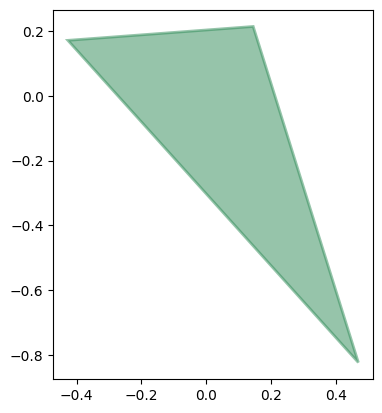

In [122]:
# Create a figure.
fig = plt.figure(num = 'Initial guess')

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the plot to equal.
ax.set_aspect('equal')

# Visualise the initial guess.
ax.fill(
    T0[0:5:2],
    T0[1:6:2],
    alpha = 0.5,
    color = 'seagreen',
    linestyle = '-',
    linewidth = 2.0
)

# Show the coordinates of the initial guess and its lengths of edges.
display(T0.reshape((3, 2)))
display(edges_lengths(T0))

# Show the plots.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


**Minimiziranje $ \lambda_{1} $ polinomom stupnja $ 4 $&hellip;**


In [0]:
min_l_0_triangle = spopt.minimize(
    polynomial_4_objective,
    T0,
    method = 'trust-constr',
    constraints = (
        {'type' : 'ineq', 'fun' : minimal_edge},
        {'type' : 'ineq', 'fun' : minimal_outer_angle},
        {'type' : 'ineq', 'fun' : maximal_outer_angle},
        {'type' : 'eq', 'fun' : ok_circumference}
    )
)


In [0]:
T = correct_orientation(min_l_0_triangle.x)


array([[ 0.27230543, -0.670152  ],
       [ 0.40897163,  0.34343376],
       [-0.50480892, -0.11595589]])

(1.022757915050977, 1.022757912142224, 0.9544841755631499)

54.15165908688011

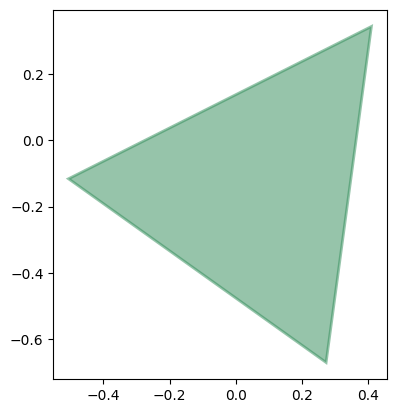

In [126]:
# Create a figure.
fig = plt.figure(num = 'Initial guess')

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the plot to equal.
ax.set_aspect('equal')

# Visualise the solution.
ax.fill(
    T[0:5:2],
    T[1:6:2],
    alpha = 0.5,
    color = 'seagreen',
    linestyle = '-',
    linewidth = 2.0
)

# Show the coordinates of the resulting triangle, its lengths of edges and the
# approximation of the minimal eigenvalue.
display(T.reshape((3, 2)))
display(edges_lengths(T))
display(polynomial_4_objective(T))

# Show the plots.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


In [0]:
# Free the memory.
del min_l_0_triangle
del T


**Minimiziranje $ \lambda_{1} $ polinomom stupnja $ 5 $&hellip;**


In [129]:
min_l_0_triangle = spopt.minimize(
    polynomial_5_objective,
    T0,
    method = 'trust-constr',
    constraints = (
        {'type' : 'ineq', 'fun' : minimal_edge},
        {'type' : 'ineq', 'fun' : minimal_outer_angle},
        {'type' : 'ineq', 'fun' : maximal_outer_angle},
        {'type' : 'eq', 'fun' : ok_circumference}
    )
)


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning

In [0]:
T = correct_orientation(min_l_0_triangle.x)


array([[ 0.24849315, -0.67355334],
       [ 0.47567122,  0.30030978],
       [-0.48128522,  0.01014454]])

(1.0000096266180076, 0.9999807466756141, 1.0000096267064067)

53.1834529253965

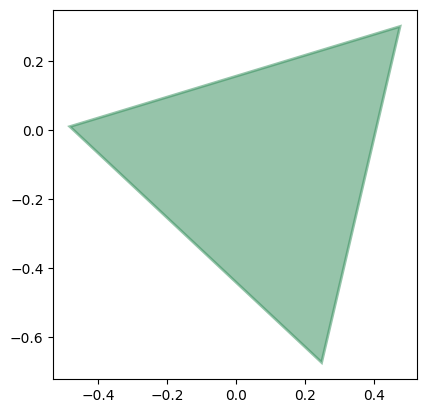

In [131]:
# Create a figure.
fig = plt.figure(num = 'Initial guess')

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the plot to equal.
ax.set_aspect('equal')

# Visualise the solution.
ax.fill(
    T[0:5:2],
    T[1:6:2],
    alpha = 0.5,
    color = 'seagreen',
    linestyle = '-',
    linewidth = 2.0
)

# Show the coordinates of the resulting triangle, its lengths of edges and the
# approximation of the minimal eigenvalue.
display(T.reshape((3, 2)))
display(edges_lengths(T))
display(polynomial_5_objective(T))

# Show the plot.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


In [0]:
# Free the memory.
del min_l_0_triangle
del T


**Minimiziranje $ \lambda_{1} $ neuronskom mrežom&hellip;**


In [134]:
min_l_0_triangle = spopt.minimize(
    nn_objective,
    T0,
    method = 'trust-constr',
    constraints = (
        {'type' : 'ineq', 'fun' : minimal_edge},
        {'type' : 'ineq', 'fun' : minimal_outer_angle},
        {'type' : 'ineq', 'fun' : maximal_outer_angle},
        {'type' : 'eq', 'fun' : ok_circumference}
    )
)


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


In [0]:
T = correct_orientation(min_l_0_triangle.x)


array([[ 0.45560921, -0.68103556],
       [ 0.37947483,  0.2618301 ],
       [-0.4577219 ,  0.09918746]])

(0.945934502768324, 0.8528487515091318, 1.2012167457225444)

59.70124816894531

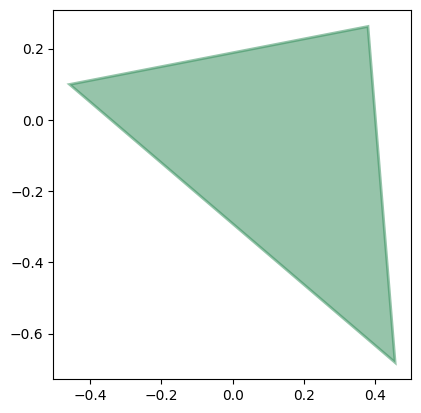

In [136]:
# Create a figure.
fig = plt.figure(num = 'Initial guess')

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the plot to equal.
ax.set_aspect('equal')

# Visualise the solution.
ax.fill(
    T[0:5:2],
    T[1:6:2],
    alpha = 0.5,
    color = 'seagreen',
    linestyle = '-',
    linewidth = 2.0
)

# Show the coordinates of the resulting triangle, its lengths of edges and the
# approximation of the minimal eigenvalue.
display(T.reshape((3, 2)))
display(edges_lengths(T))
display(nn_objective(T))

# Show the plot.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


In [0]:
# Free the memory.
del min_l_0_triangle
del T


**Minimiziranje $ \lambda_{1} $ konvolucijskom neuronskom mrežom&hellip;**


In [139]:
min_l_0_triangle = spopt.minimize(
    cnn_objective,
    T0,
    method = 'trust-constr',
    constraints = (
        {'type' : 'ineq', 'fun' : minimal_edge},
        {'type' : 'ineq', 'fun' : minimal_outer_angle},
        {'type' : 'ineq', 'fun' : maximal_outer_angle},
        {'type' : 'eq', 'fun' : ok_circumference}
    )
)


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


In [0]:
T = correct_orientation(min_l_0_triangle.x)


array([[ 0.60662061, -1.22210454],
       [ 0.35337158, -0.14117873],
       [-0.25865052, -0.31506927]])

(1.1101962322648362, 0.6362459937271355, 1.2535577740080297)

74.05309295654297

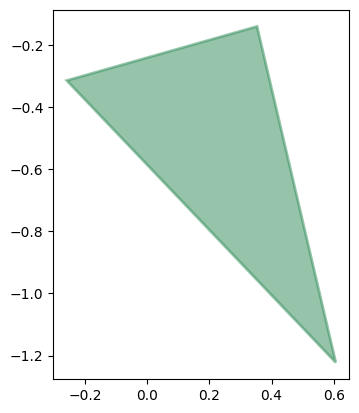

In [141]:
# Create a figure.
fig = plt.figure(num = 'Initial guess')

# Create a subplot.
ax = fig.add_subplot(1, 1, 1)

# Set the aspect of the plot to equal.
ax.set_aspect('equal')

# Visualise the solution.
ax.fill(
    T[0:5:2],
    T[1:6:2],
    alpha = 0.5,
    color = 'seagreen',
    linestyle = '-',
    linewidth = 2.0
)

# Show the coordinates of the resulting triangle, its lengths of edges and the
# approximation of the minimal eigenvalue.
display(T.reshape((3, 2)))
display(edges_lengths(T))
display(cnn_objective(T))

# Show the plot.
plt.show()


In [0]:
# Free the memory.
del fig
del ax


In [0]:
# Free the memory.
del min_l_0_triangle
del T


In [0]:
# Free the memory.
del C
del T0
del ok_circumference
del polynomial_4_objective
del polynomial_5_objective


### Zaključak <a class="anchor" id="min-conclusion"></a>


Očekivano, modeli koji su na najnižim vrijednostima najtočniji&mdash;polinomni modeli, to jest, modeli linearne regresije&mdash;najbolje su minimizirali vrijednosti na trokutima. Najveće je iznenađenje neuronska mreža koja vrijednosti minimizira na vidno tupokutnim trokutima. Konvolucijska neuronska mreža, iako loše predviđa vrijednost, trokut na kojem se taj minimum postiže solidno *pogađa*.


In [0]:
# Free the memory.
del polynomial_4
del polynomial_terms_4
del polynomial_5
del polynomial_terms_5
del nn
del X_mean
del X_std
del cnn
del res


## Zaključak <a class="anchor" id="conclusion"></a>


Nijedan od predstavljenih modela nije loš u predviđanju svojstvenih vrijednosti Laplaceovog operatora na trokutima. Daljnjim istraživanjem mogao bi se naći jednostavniji model neuronske mreže koji bi bio barem jednako dobar kao predstavljeni model, koji je, s obzirom na veličinu ulaza, možda prekompleksan. Također, mogla bi se proučiti generalizabilnost predstavljenih modela na ostalim mnogokutima, pri čemu je najfleksibilniji model konvolucijske neuronske mreže.


## Literatura <a class="anchor" id="bibliography"></a>


1.   K. Mills, M. Spanner, I. Tamblyn, *Deep Learning and the Schr&ouml;dinger Equation*, 2017, arXiv: [`1702.01361 [cond-mat.mtrl-sci]`](https://arxiv.org/abs/1702.01361). <a class="anchor" id="bib-Mills17"></a>


In [146]:
# Free the memory.
gc.collect()


11617